In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
results_dir = "[3] Test Input"

output_dir = "[5] Tester Results"
os.makedirs(output_dir, exist_ok=True)

recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

In [3]:
# ...existing code...

dfs = {}
dfs_fit = {}

files = [file for file in os.listdir(results_dir) if file.endswith(('.xlsx', '.xls'))]

for file in files:
    file_path = os.path.join(results_dir, file)
    key = file.split('.')[0]
    if key.endswith('_FIT'):
        dfs_fit[key] = pd.read_excel(file_path)
    else:
        dfs[key] = pd.read_excel(file_path)

print("Raw dataframes:", list(dfs.keys()))
print("Fit dataframes:", list(dfs_fit.keys()))
print(f"Found {len(dfs)} raw and {len(dfs_fit)} fit dataframes in {results_dir}.")
if len(dfs) != len(dfs_fit):
    print("Warning: Mismatch between raw and fit dataframes!")

experiments = dfs[list(dfs.keys())[1]]['experiment'].unique().tolist()
variables = dfs[list(dfs.keys())[1]].columns[4:].tolist()
parameters = dfs[list(dfs.keys())[1]].columns[:4].tolist()
print(f"\nFound {len(experiments)} experiments, {len(variables)} variables and {len(parameters)} parameters:")
print(" "+', '.join(experiments))
print(" "+', '.join(variables))
print(" "+', '.join(parameters))

all_experiments = set()
for df in dfs.values():
    if 'experiment' in df.columns:
        all_experiments.update(df['experiment'].dropna().unique())

experiments = sorted(all_experiments)
print(f"All experiments found across raw dataframes ({len(experiments)}):")
print(" " + ', '.join(map(str, experiments)))

# ...existing code...

Raw dataframes: ['RESULTS', 'RESULTS_ASR_control', 'RESULTS_MERGED', 'RESULTS_MERGED_ASR_control', 'RESULTS_MERGED_DATE', 'RESULTS_MERGED_DATE_ASR_control', 'RESULTS_MERGED_EXP', 'RESULTS_MT10', 'RESULTS_MT10_ASR_control', 'RESULTS_MTT_MERGED', 'RESULTS_MTT_MERGED_ASR_control', 'RESULTS_MTT_MERGED_DATE', 'RESULTS_MTT_MERGED_DATE_ASR_control', 'RESULTS_MTT_MERGED_EXP', 'RESULTS_T10', 'RESULTS_T10_ASR_control', 'RESULTS_TT_MERGED', 'RESULTS_TT_MERGED_ASR_control', 'RESULTS_TT_MERGED_DATE', 'RESULTS_TT_MERGED_DATE_ASR_control', 'RESULTS_TT_MERGED_EXP', 'SegmentOrder', 'SegmentOrder_ASR_control']
Fit dataframes: []
Found 23 raw and 0 fit dataframes in [3] Test Input.

Found 1 experiments, 9 variables and 4 parameters:
 ASR_control
 reactionTime, peakTime, difference, peakValue, PTPA, PTTA, RMS, tau, AUC
 animal, sex, date, experiment
All experiments found across raw dataframes (19):
 ASR_control, gap_depth, gap_duration_10, gap_duration_20, gap_duration_4, gap_duration_50, gap_duration_8, 

---

In [4]:
# Count how many peakTime values are exactly 30 in RESULTS_MTT_MERGED (out of 324)
import pandas as pd

df = dfs['RESULTS_MTT_MERGED']
count_30 = (df['peakTime'] == 30).sum()
total = len(df)
print(f"Number of peakTime values equal to 30: {count_30} out of {total} ({count_30/total:.2%})")

Number of peakTime values equal to 30: 2 out of 306 (0.65%)


---

Expectations:
- date fluctuations
- no repetition differences
- sex differences in strength metrics
- experiment differences, in particular with increased gap / offset

---

## Average Reaction Time

In [5]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8, and print the maximum value

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']
vals = df['reactionTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
print(f"Maximum reaction time (IQR filtered): {filtered.max():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Reaction time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Reaction time is significantly higher than 6.")
else:
    print("Reaction time is not significantly higher than 6 or 8.")

Mean reaction time (IQR filtered): 2.00
Maximum reaction time (IQR filtered): 2.00
T-test vs 8: statistic=-inf, p-value=1.000e+00
T-test vs 6: statistic=-inf, p-value=1.000e+00
Reaction time is not significantly higher than 6 or 8.


c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [6]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean reaction time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean reaction time (IQR filtered): 2.00
T-test vs 8: statistic=-inf, p-value=1.000e+00
T-test vs 6: statistic=-inf, p-value=1.000e+00
Reaction time is not significantly higher than 6 or 8.

Sex: male
Mean reaction time (IQR filtered): 2.00
T-test vs 8: statistic=-inf, p-value=1.000e+00
T-test vs 6: statistic=-inf, p-value=1.000e+00
Reaction time is not significantly higher than 6 or 8.


c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [7]:
import pandas as pd
from scipy.stats import ttest_1samp, t
import numpy as np

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['reactionTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    n = len(filtered)
    mean = filtered.mean()
    sem = filtered.sem()
    # 95% confidence interval
    ci = t.interval(0.95, n-1, loc=mean, scale=sem) if n > 1 else (np.nan, np.nan)
    print(f"\nSex: {sex}")
    print(f"Mean reaction time (IQR filtered): {mean:.2f}")
    print(f"95% CI: ({ci[0]:.2f}, {ci[1]:.2f})")
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Reaction time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Reaction time is significantly higher than 6.")
    else:
        print("Reaction time is not significantly higher than 6 or 8.")


Sex: female
Mean reaction time (IQR filtered): 2.00
95% CI: (nan, nan)
T-test vs 8: statistic=-inf, p-value=1.000e+00
T-test vs 6: statistic=-inf, p-value=1.000e+00
Reaction time is not significantly higher than 6 or 8.

Sex: male
Mean reaction time (IQR filtered): 2.00
95% CI: (nan, nan)
T-test vs 8: statistic=-inf, p-value=1.000e+00
T-test vs 6: statistic=-inf, p-value=1.000e+00
Reaction time is not significantly higher than 6 or 8.


c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2324: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2323: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Li

In [8]:
# Test if the average reaction time (excluding outliers) is significantly higher than the range 6-8

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']
vals = df['peakTime'].dropna()

# Exclude outliers using IQR
q1 = vals.quantile(0.25)
q3 = vals.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
filtered = vals[(vals >= lower) & (vals <= upper)]

# Test against the upper bound (8)
stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
# Test against the lower bound (6)
stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')

print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")

if p_8 < 0.05:
    print("Peak time is significantly higher than 8.")
elif p_6 < 0.05:
    print("Peak time is significantly higher than 6.")
else:
    print("Peak time is not significantly higher than 6 or 8.")

Mean peak time (IQR filtered): 26.38
T-test vs 8: statistic=69.943, p-value=3.757e-190
T-test vs 6: statistic=77.555, p-value=4.143e-203
Peak time is significantly higher than 8.


In [9]:
# Test if the average peak time (excluding outliers) is significantly higher than the range 6-8, split by sex

import pandas as pd
from scipy.stats import ttest_1samp

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    vals = df[df['sex'] == sex]['peakTime'].dropna()
    # Exclude outliers using IQR
    q1 = vals.quantile(0.25)
    q3 = vals.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    filtered = vals[(vals >= lower) & (vals <= upper)]
    # Test against the upper bound (8)
    stat_8, p_8 = ttest_1samp(filtered, 8, alternative='greater')
    # Test against the lower bound (6)
    stat_6, p_6 = ttest_1samp(filtered, 6, alternative='greater')
    print(f"\nSex: {sex}")
    print(f"Mean peak time (IQR filtered): {filtered.mean():.2f}")
    print(f"T-test vs 8: statistic={stat_8:.3f}, p-value={p_8:.3e}")
    print(f"T-test vs 6: statistic={stat_6:.3f}, p-value={p_6:.3e}")
    if p_8 < 0.05:
        print("Peak time is significantly higher than 8.")
    elif p_6 < 0.05:
        print("Peak time is significantly higher than 6.")
    else:
        print("Peak time is not significantly higher than 6 or 8.")


Sex: female
Mean peak time (IQR filtered): 29.47
T-test vs 8: statistic=105.403, p-value=1.092e-140
T-test vs 6: statistic=115.224, p-value=2.621e-146
Peak time is significantly higher than 8.

Sex: male
Mean peak time (IQR filtered): 23.59
T-test vs 8: statistic=45.426, p-value=1.228e-90
T-test vs 6: statistic=51.254, p-value=4.042e-98
Peak time is significantly higher than 8.


---

## Repetition Differences

In [10]:
# ...existing code...

# Test if the value changes over repetitions (trial order) for each variable in RESULTS_MTT (parametric, assume normality)
import ast
from scipy.stats import f_oneway

def test_repetition_effect_parametric(df, variables, max_reps=5, alpha=0.05):
    results = []
    for var in variables:
        # Convert string lists to actual lists if needed
        vals = df[var].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
        # Filter to rows that are lists and have enough length
        list_rows = vals[vals.apply(lambda x: isinstance(x, list) and len(x) > 1)]
        if list_rows.empty:
            continue
        # Find the minimum length across all lists (to avoid index errors)
        min_len = min(list_rows.apply(len))
        min_len = min(min_len, max_reps)
        # Gather values by repetition index
        rep_groups = []
        for i in range(min_len):
            group = list_rows.apply(lambda x: x[i] if len(x) > i else np.nan).dropna()
            if len(group) > 1:
                rep_groups.append(group.values)
        if len(rep_groups) < 2:
            continue
        # ANOVA (parametric) test across repetitions
        stat, p = f_oneway(*rep_groups)
        if p < alpha:
            mean_diff = np.mean(rep_groups[0]) - np.mean(rep_groups[-1])
            results.append({'variable': var, 'stat': stat, 'p': p, 'test': 'anova', 'mean_diff': mean_diff})
    return pd.DataFrame(results)

repetition_effects_parametric = test_repetition_effect_parametric(dfs['RESULTS'], variables)
test_repetition_parametric = pd.DataFrame(repetition_effects_parametric)

print(test_repetition_parametric) if not repetition_effects_parametric.empty else print("No significant repetition effects found for any variable (parametric).")
test_repetition_parametric.to_excel(os.path.join(output_dir, "TEST_REPETITION_PARAMETRIC.xlsx"), index=False)

  variable     stat         p   test   mean_diff
0      AUC  4.52859  0.033733  anova  264.431765


# ---> merge across repetitions

---

## Intratrial Differences

In [11]:
# Check for intratrial differences: do variables increase or decrease across one animal's experiment?

import pandas as pd
from scipy.stats import linregress

# Load the lookup table DataFrame (assume it's named "SegmentOrder.xlsx" and in Analyzer Results)
lookup_path = os.path.join("[1] Peakfinder Results", "SegmentOrder.xlsx")
lookup_df = pd.read_excel(lookup_path)

# Load main results
df = dfs['RESULTS_MERGED']

# For each animal and date, check variable trends across experiment order
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
trend_results = []

# ...existing code...

for (animal, date), group in lookup_df.groupby(['animal', 'date']):
    order_map = {row['experiment']: row['order_index'] for _, row in group.iterrows()}
    df_sub = df[(df['animal'] == animal) & (df['date'] == date)].copy()
    df_sub['order_index'] = df_sub['experiment'].map(order_map)
    df_sub = df_sub[df_sub['order_index'].notnull()]
    df_sub = df_sub.sort_values('order_index')
    n_trials = len(df_sub)
    for var in variables:
        vals = df_sub[var].dropna()
        order = df_sub['order_index'].loc[vals.index]
        if len(vals) > 1:
            slope, intercept, r, p, _ = linregress(order, vals)
            # Percent change per minute
            start = vals.iloc[0]
            end = vals.iloc[-1]
            percent_change = ((end - start) / start) * 100 if start != 0 else None
            percent_change_per_minute = percent_change / 30 if percent_change is not None else None
            trend_results.append({
                'animal': animal,
                'date': date,
                'variable': var,
                'slope_per_trial': slope,
                'r': r,
                'p': p,
                'direction': 'increase' if slope > 0 else 'decrease' if slope < 0 else 'none',
                'percent_change': percent_change,
                'percent_change_per_minute': percent_change_per_minute
            })

# ...existing code...

trend_df = pd.DataFrame(trend_results)
trend_df = trend_df[trend_df['p'] < 0.05].reset_index(drop=True)  # Only keep significant results

print(trend_df)
trend_df.to_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"), index=False)
# ...existing code...

      animal    date    variable  slope_per_trial         r         p  \
0   Animal15  June26         tau        -0.177492 -0.519627  0.032530   
1   Animal15   May20    peakTime         0.124802  0.615937  0.008474   
2   Animal15   May20  difference         0.121646  0.612257  0.008989   
3    Animal2  June26    peakTime        -0.223259 -0.639759  0.005680   
4    Animal2  June26  difference        -0.223259 -0.639759  0.005680   
5    Animal2  June26   peakValue         0.415087  0.555856  0.020512   
6    Animal2  June26        PTPA         0.438724  0.606512  0.009844   
7    Animal2  June26         RMS         0.154212  0.548805  0.022524   
8    Animal2  June26         tau         0.279883  0.569044  0.017127   
9    Animal2  June26         AUC        38.923869  0.645968  0.005090   
10   Animal4   May20   peakValue         0.545900  0.545242  0.023598   
11   Animal4   May20        PTPA         0.534210  0.554339  0.020933   
12   Animal4   May20        PTTA         0.478388  

In [12]:
import pandas as pd

# Load significant intratrial trends
trend_df = pd.read_excel(os.path.join(output_dir, "INTRATRIAL_DIFFERENCES_SIGNIFICANT.xlsx"))

# Define metrics
strength_metrics = ['AUC', 'PTPA', 'PTTA', 'RMS', 'peakValue']
reaction_metrics = ['reactionTime', 'peakTime']

# Only keep strength metrics
trend_strength = trend_df[trend_df['variable'].isin(strength_metrics)]
avg_strength_percent_change_per_minute = trend_strength['percent_change_per_minute'].mean()
print(f"Average percent change per minute (strength metrics, significant results): {avg_strength_percent_change_per_minute:.3f}")

# Only keep reaction metrics
trend_reaction = trend_df[trend_df['variable'].isin(reaction_metrics)]
avg_reaction_percent_change_per_minute = trend_reaction['percent_change_per_minute'].mean()
print(f"Average percent change per minute (reaction metrics, significant results): {avg_reaction_percent_change_per_minute:.3f}")

Average percent change per minute (strength metrics, significant results): 0.891
Average percent change per minute (reaction metrics, significant results): -0.085


---

In [13]:
import pandas as pd
import statsmodels.formula.api as smf

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for var in variables:
    print(f"\n=== Mixed Linear Model for {var} ===")
    try:
        model = smf.mixedlm(f'{var} ~ C(sex) + C(date) + C(experiment)', data=df, groups=df['animal']).fit()
        print(model.summary())
    except Exception as e:
        print(f"Could not fit model for {var}: {e}")


=== Mixed Linear Model for reactionTime ===
                   Mixed Linear Model Regression Results
Model:                   MixedLM      Dependent Variable:      reactionTime
No. Observations:        306          Method:                  REML        
No. Groups:              6            Scale:                   0.0402      
Min. group size:         51           Log-Likelihood:          20.1543     
Max. group size:         51           Converged:               Yes         
Mean group size:         51.0                                              
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         2.021    0.059 34.177 0.000  1.906  2.137
C(sex)[T.male]                    0.032    0.048  0.667 0.505 -0.062  0.125
C(date)[T.June26]                -0.035    0.028 -1.246 0.213 

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


                   Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       RMS      
No. Observations:         306           Method:                   REML     
No. Groups:               6             Scale:                    17.2887  
Min. group size:          51            Log-Likelihood:           -851.4038
Max. group size:          51            Converged:                Yes      
Mean group size:          51.0                                             
---------------------------------------------------------------------------
                                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------
Intercept                         9.947    2.278  4.367 0.000  5.483 14.411
C(sex)[T.male]                   12.211    2.888  4.228 0.000  6.550 17.872
C(date)[T.June26]                 8.752    0.582 15.033 0.000  7.611  9.894
C(date)[T.May20]               

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsm

# Summary of Mixed Linear Model Results

### Reaction Metrics
- **reactionTime**
  - **Sex:** No significant effect.
  - **Date:** Both June26 and May20 are significantly lower than the reference (p < 0.001).
  - **Experiment:** Most not significant, but offset_PPI_14, _20, _6, _8 show significantly higher reactionTime (p < 0.05). tone_in_noise is significantly lower (p = 0.002).
- **peakTime & difference**
  - No significant effects for sex, date, or experiment.

### Strength Metrics (peakValue, PTPA, PTTA, RMS, AUC)
- **Sex:** Males have significantly higher values for all except tau and AUC (p < 0.05).
- **Date:** Both June26 and May20 are significantly higher than the reference (p < 0.001).
- **Experiment:** offset_PPI variants and tone_in_noise are significantly lower (p < 0.05 for many variants). Other experiments mostly not significant.

### tau
- **Sex:** Males have significantly lower tau (p = 0.017).
- **Date:** May20 is significantly lower than reference (p = 0.002).
- **Experiment:** No significant effects.

### Summary
- Sex and date strongly affect strength metrics, but not reaction metrics.
- offset_PPI and tone_in_noise experiments consistently reduce strength metrics and reactionTime.
- peakTime and difference are not significantly affected by any factor.

# ---> reaction time is the best reaction metric
# ---> AUC might be useful for avoiding sex differences
# ---> males have higher strength
# ---> recording date affects strength most
# ---> especially tone in noise and offset PPI cause lower ASR strength (in line with %PPI results)
# ---> tau varies by sex and date, much like strength, but unlike strength is not affected by experiment

---

## Date Differences

In [14]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

date_results_parametric = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        # Parametric ANOVA for all metrics
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = f_oneway(*groups)
            posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None
            if p < 0.05:
                try:
                    # Tukey HSD posthoc (parametric)
                    tukey = sp.posthoc_tukey_hsd(df_sex, val_col=var, group_col='date')
                    min_p = tukey.replace(0, float('nan')).min().min()
                    idx = tukey.stack().idxmin()
                    date1, date2 = idx
                    vals1 = df_sex[df_sex['date'] == date1][var].dropna()
                    vals2 = df_sex[df_sex['date'] == date2][var].dropna()
                    mean_diff = vals1.mean() - vals2.mean()
                    # Cohen's d for effect size
                    pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                    eff = mean_diff / pooled_std if pooled_std != 0 else None
                    posthoc_p = min_p
                    posthoc_test = "Tukey HSD"
                except Exception:
                    posthoc_p, posthoc_test, mean_diff = None, "Tukey HSD", None
        else:
            stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
        date_results_parametric.append({
            'sex': sex,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'date1': date1,
            'date2': date2,
            'effect_strength': eff,
            'mean_diff': mean_diff
        })

test_date_parametric = pd.DataFrame(date_results_parametric)
print(test_date_parametric)

test_date_parametric.to_excel(os.path.join(output_dir, "TEST_DATE_PARAMETRIC.xlsx"), index=False)
# ...existing code...

       sex      variable       stat             p  significant     posthoc_p  \
0   female  reactionTime   0.388098  6.790248e-01        False           NaN   
1   female      peakTime  19.385695  3.248115e-08         True  6.355072e-08   
2   female    difference  19.312430  3.442903e-08         True  7.351804e-08   
3   female     peakValue  61.890548  2.521071e-20         True  4.551914e-15   
4   female          PTPA  60.273565  6.146453e-20         True  4.551914e-15   
5   female          PTTA  54.061589  2.088427e-18         True  4.551914e-15   
6   female           RMS  60.220045  6.331607e-20         True  4.551914e-15   
7   female           tau   7.818976  5.886475e-04         True  1.367158e-03   
8   female           AUC  66.758136  1.834405e-21         True  4.551914e-15   
9     male  reactionTime   1.903499  1.526290e-01        False           NaN   
10    male      peakTime  12.205459  1.226928e-05         True  3.340328e-05   
11    male    difference  11.951543  1.5

In [15]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

date_results_merged_sex_parametric = []

for var in variables:
    # Parametric ANOVA for all metrics, merged by sex
    groups = [group[var].dropna().values for _, group in df.groupby('date')]
    groups = [g for g in groups if len(g) > 1]
    stat, p, posthoc_p, posthoc_test, date1, date2, eff, mean_diff = None, None, None, None, None, None, None, None
    if len(groups) > 1:
        stat, p = f_oneway(*groups)
        if p < 0.05:
            try:
                tukey = sp.posthoc_tukey_hsd(df, val_col=var, group_col='date')
                min_p = tukey.replace(0, float('nan')).min().min()
                idx = tukey.stack().idxmin()
                date1, date2 = idx
                vals1 = df[df['date'] == date1][var].dropna()
                vals2 = df[df['date'] == date2][var].dropna()
                mean_diff = vals1.mean() - vals2.mean()
                pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                eff = mean_diff / pooled_std if pooled_std != 0 else None
                posthoc_p = min_p
                posthoc_test = "Tukey HSD"
            except Exception:
                posthoc_p, posthoc_test, mean_diff = None, "Tukey HSD", None
    date_results_merged_sex_parametric.append({
        'variable': var,
        'stat': stat,
        'p': p,
        'significant': p is not None and p < 0.05,
        'posthoc_p': posthoc_p,
        'posthoc_test': posthoc_test,
        'date1': date1,
        'date2': date2,
        'effect_strength': eff,
        'mean_diff': mean_diff
    })

test_date_merged_sex_parametric = pd.DataFrame(date_results_merged_sex_parametric)
print(test_date_merged_sex_parametric)

test_date_merged_sex_parametric.to_excel(os.path.join(output_dir, "TEST_DATE_MERGED_SEX_PARAMETRIC.xlsx"), index=False)
# ...existing code...

       variable       stat             p  significant     posthoc_p  \
0  reactionTime   0.792482  4.536558e-01        False           NaN   
1      peakTime  16.989481  1.015631e-07         True  3.149515e-07   
2    difference  16.684059  1.336941e-07         True  3.863941e-07   
3     peakValue  32.478393  1.660889e-13         True  6.006307e-14   
4          PTPA  33.299643  8.458495e-14         True  2.675637e-14   
5          PTTA  34.999420  2.112880e-14         True  5.760739e-06   
6           RMS  30.392544  9.344523e-13         True  3.552714e-13   
7           tau   0.402586  6.689457e-01        False           NaN   
8           AUC  28.475063  4.654202e-12         True  3.340328e-12   

  posthoc_test    date1   date2  effect_strength    mean_diff  
0         None     None    None              NaN          NaN  
1    Tukey HSD   June26   May20        -0.749787    -3.335948  
2    Tukey HSD   June26   May20        -0.745833    -3.311438  
3    Tukey HSD  April16  June26  

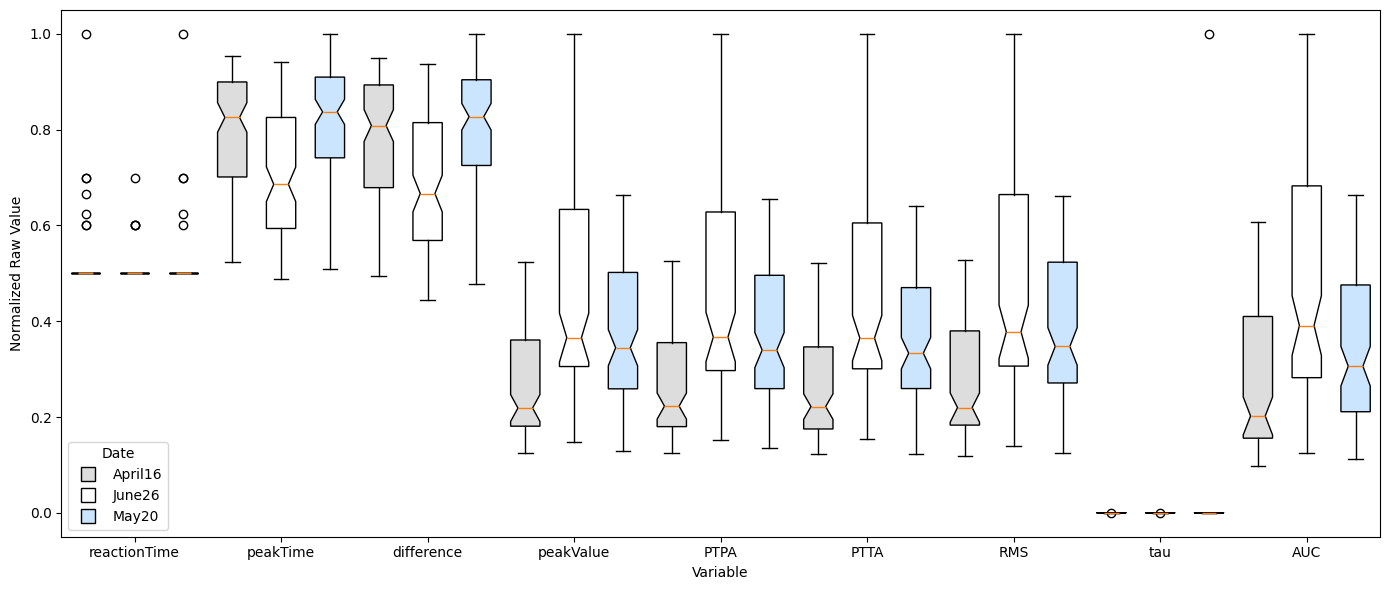

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE_PARAMETRIC.xlsx"))
df = dfs['RESULTS_MERGED']

# Only keep significant results
sig = test_date  # [test_date['significant'] == True]

# Get all unique dates and variables
dates = df['date'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/date, EXCLUDE negative values
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, date in enumerate(dates):
        vals = df[df['date'] == date][var].dropna()
        vals = vals[vals >= 0]  # Exclude negative values
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i * len(dates) + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append(['#DDDDDD', '#FFFFFF', '#CCE5FF', '#FFCCCC', '#CCFFCC'][j % 5])  # Color by date

plt.figure(figsize=(14, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i * len(dates) + (len(dates) - 1) / 2 for i in range(len(variables))], variables)
plt.ylabel('Normalized Raw Value')
plt.xlabel('Variable')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label=dates[0], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label=dates[1], linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#CCE5FF', label=dates[2], linestyle='None')
], title='Date', loc='lower left')
plt.tight_layout()
plt.show()

In [17]:
import pandas as pd

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date']]

# Calculate mean for each variable, grouped by date and sex
mean_table = df.groupby(['date', 'sex'])[variables].mean().reset_index()

print(mean_table)

# Optionally, save to Excel
mean_table.to_excel(os.path.join(output_dir, "MEAN_VARIABLES_BY_DATE_SEX.xlsx"), index=False)

      date     sex  reactionTime   peakTime  difference  peakValue       PTPA  \
0  April16  female      2.007843  29.749673   27.741830  26.795098  26.373428   
1  April16    male      2.101307  24.466667   22.365359  55.488889  53.649225   
2   June26  female      2.023529  27.317647   25.294118  44.864706  44.050755   
3   June26    male      2.015686  21.366013   19.350327  91.174510  88.030708   
4    May20  female      2.039216  30.423529   28.384314  39.046078  38.409572   
5    May20    male      2.049020  24.932026   22.883007  74.623203  72.163355   

        PTTA        RMS           tau          AUC  
0  25.062134   8.427739     24.220314   953.149464  
1  50.092411  18.428065     38.455268  2517.502601  
2  41.932267  14.735000     28.445755  1847.172755  
3  82.082296  29.625748     36.552399  4003.783709  
4  36.974223  12.540431     24.600507  1321.504252  
5  66.663480  24.281595  15204.569585  2972.337703  


In [18]:
import pandas as pd

df = dfs['RESULTS_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']

# Calculate mean for each metric by date
mean_by_date = df.groupby('date')[strength_metrics].mean()

# Calculate mean difference between dates for each metric
mean_diff = mean_by_date.max() - mean_by_date.min()
mean_diff = mean_diff.rename('mean_difference')

# Combine for display
result = mean_by_date.T
result['mean_difference'] = mean_diff

print(result)

# Optionally save to Excel
result.to_excel(os.path.join(output_dir, "STRENGTH_METRIC_MEAN_DIFF_BY_DATE.xlsx"))

date           April16       June26        May20  mean_difference
peakValue    41.141993    68.019608    56.834641        26.877614
PTPA         40.011326    66.040732    55.286464        26.029405
PTTA         37.577273    62.007281    51.818851        24.430009
RMS          13.427902    22.180374    18.411013         8.752472
tau          31.337791    32.499077  7614.585046      7583.247255
AUC        1735.326033  2925.478232  2146.920977      1190.152199


In [19]:
# Count how many sex/variable groups show significant date deviations

import pandas as pd
from scipy.stats import kruskal

df = dfs['RESULTS_MTT_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

significant_count = 0
results = []

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    for var in variables:
        groups = [group[var].dropna().values for _, group in df_sex.groupby('date')]
        groups = [g for g in groups if len(g) > 1]
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            if p < 0.05:
                significant_count += 1
                results.append({'sex': sex, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/variable groups with significant date deviations: {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_DATE_SPLIT.xlsx"), index=False)

Number of sex/variable groups with significant date deviations: 16


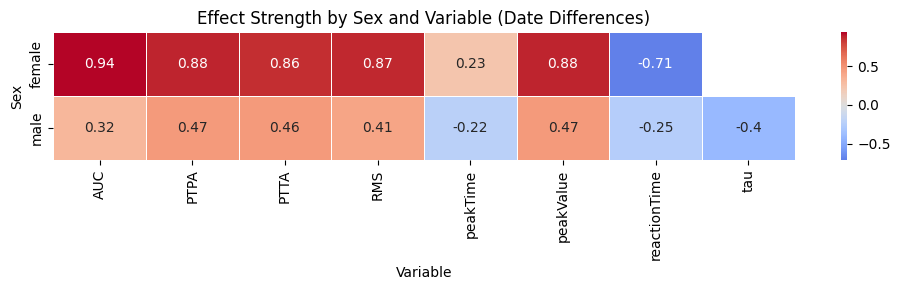

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Paste your results as a DataFrame
data = {
    "sex": ["female"]*8 + ["male"]*8,
    "variable": ["AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau",
                 "AUC", "PTPA", "PTTA", "RMS", "peakTime", "peakValue", "reactionTime", "tau"],
    "effect_strength": [0.940329, 0.877915, 0.859396, 0.871742, 0.229424, 0.878944, -0.711248, np.nan,
                       0.316187, 0.466392, 0.463649, 0.414952, -0.223594, 0.467078, -0.247942, -0.403978]
}
df = pd.DataFrame(data)

# Pivot for heatmap (sex x variable)
heatmap_data = df.pivot(index="sex", columns="variable", values="effect_strength")

plt.figure(figsize=(10, 3))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Sex and Variable (Date Differences)")
plt.ylabel("Sex")
plt.xlabel("Variable")
plt.tight_layout()
plt.show()

In [21]:
# Calculate average effect strength for date differences, split by sex

import pandas as pd

# Load your results (replace with actual path if needed)
test_date = pd.read_excel(os.path.join(output_dir, "TEST_DATE_PARAMETRIC.xlsx"))

# Only keep significant results
sig = test_date[test_date['significant'] == True]

# Calculate average effect strength for each sex
avg_female = sig[sig['sex'] == 'female']['effect_strength'].mean()
avg_male = sig[sig['sex'] == 'male']['effect_strength'].mean()

# Calculate how much stronger the effect is for females
strength_ratio = avg_female / avg_male if avg_male != 0 else None
strength_diff = avg_female - avg_male

print(f"Average effect strength (female): {avg_female:.3f}")
print(f"Average effect strength (male): {avg_male:.3f}")
print(f"Females have {strength_ratio:.2f}x stronger effect on average (ratio), or {strength_diff:.3f} higher (difference).")

Average effect strength (female): -1.745
Average effect strength (male): -1.405
Females have 1.24x stronger effect on average (ratio), or -0.339 higher (difference).


# ---> split by date, especially for females (may be estrous cycle?)

---

In [22]:
# ...existing code...

import pandas as pd
from scipy.stats import ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

sex_diff_results = []

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for var in variables:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        mean_diff = vals_male.mean() - vals_female.mean() if len(vals_male) > 0 and len(vals_female) > 0 else None
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
            # Cohen's d for effect size
            pooled_std = ((vals_male.std(ddof=1) ** 2 + vals_female.std(ddof=1) ** 2) / 2) ** 0.5
            eff = mean_diff / pooled_std if pooled_std != 0 else None
            # Tukey HSD posthoc
            try:
                data = pd.DataFrame({var: pd.concat([vals_male, vals_female]),
                                    'group': ['male'] * len(vals_male) + ['female'] * len(vals_female)})
                tukey = sp.posthoc_tukey_hsd(data, val_col=var, group_col='group')
                posthoc_p = tukey.loc['male', 'female']
                posthoc_test = "Tukey HSD"
            except Exception:
                posthoc_p = None
                posthoc_test = "Tukey HSD"
        else:
            stat, p, eff, posthoc_p, posthoc_test = None, None, None, None, None
        sex_diff_results.append({
            'date': date,
            'variable': var,
            'stat': stat,
            'p': p,
            'significant': p is not None and p < 0.05,
            'effect_strength': eff,
            'posthoc_p': posthoc_p,
            'posthoc_test': posthoc_test,
            'mean_diff': mean_diff,
            'test': 'ttest_ind'
        })

test_sex = pd.DataFrame(sex_diff_results)
print(test_sex)

test_sex.to_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"), index=False)
# ...existing code...

       date      variable       stat             p  significant  \
0   April16  reactionTime   1.965198  5.466247e-02        False   
1   April16      peakTime  -8.109469  9.309850e-12         True   
2   April16    difference  -8.286101  4.210151e-12         True   
3   April16     peakValue  16.094320  3.524875e-24         True   
4   April16          PTPA  15.977557  3.854158e-24         True   
5   April16          PTTA  15.203717  2.830349e-23         True   
6   April16           RMS  16.552252  5.434965e-25         True   
7   April16           tau   7.642608  1.530186e-10         True   
8   April16           AUC  15.908072  1.294061e-22         True   
9    June26  reactionTime  -0.381246  7.039787e-01        False   
10   June26      peakTime  -8.842640  3.621027e-14         True   
11   June26    difference  -8.819896  4.022932e-14         True   
12   June26     peakValue  11.142067  1.668016e-16         True   
13   June26          PTPA  10.900693  3.496988e-16         Tru

In [23]:
import pandas as pd

# Replace with your actual DataFrame if needed
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"))
# For your pasted data, assume it's in a DataFrame called df

# Only keep numeric columns for averaging
cols_to_avg = ['stat', 'p', 'effect_strength', 'mean_diff']
avg_df = df.groupby('variable')[cols_to_avg].mean().reset_index()

# Optionally, keep the first posthoc_test and test type for each variable
for col in ['posthoc_test', 'test']:
    avg_df[col] = df.groupby('variable')[col].first().values

print(avg_df)
avg_df.to_excel(os.path.join(output_dir, "TEST_SEX_AVG_ACROSS_DATES_PARAMETRIC.xlsx"), index=False)

       variable       stat             p  effect_strength    mean_diff  \
0           AUC  14.339536  8.730299e-18         2.839651  1790.599181   
1          PTPA  14.041105  1.165663e-16         2.780553    35.003178   
2          PTTA  13.394821  9.704334e-17         2.652570    31.623188   
3           RMS  13.947621  1.521096e-15         2.762041    12.210746   
4    difference  -8.431117  3.752134e-12        -1.669610    -5.607190   
5      peakTime  -8.351671  6.624719e-12        -1.653877    -5.575381   
6     peakValue  14.260867  5.560053e-17         2.824072    36.860240   
7  reactionTime   0.598421  5.305982e-01         0.118505     0.031808   
8           tau   4.887444  1.764913e-01         0.967858  5067.436892   

  posthoc_test       test  
0    Tukey HSD  ttest_ind  
1    Tukey HSD  ttest_ind  
2    Tukey HSD  ttest_ind  
3    Tukey HSD  ttest_ind  
4    Tukey HSD  ttest_ind  
5    Tukey HSD  ttest_ind  
6    Tukey HSD  ttest_ind  
7    Tukey HSD  ttest_ind  
8    Tu

In [24]:
import pandas as pd

# Load the results
df = pd.read_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"))

# Columns to summarize
cols_to_range = ['stat', 'p', 'effect_strength', 'mean_diff']

# Group by variable and get mean for stat/p, min/max for effect_strength/mean_diff
summary = df.groupby('variable').agg(
    stat_mean=('stat', 'mean'),
    p_mean=('p', 'mean'),
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max'),
    posthoc_test=('posthoc_test', 'first'),
    test=('test', 'first')
).reset_index()

print(summary)
summary.to_excel(os.path.join(output_dir, "TEST_SEX_RANGE_ACROSS_DATES_PARAMETRIC.xlsx"), index=False)

       variable  stat_mean        p_mean  effect_strength_min  \
0           AUC  14.339536  8.730299e-18             2.227288   
1          PTPA  14.041105  1.165663e-16             2.158659   
2          PTTA  13.394821  9.704334e-17             2.135786   
3           RMS  13.947621  1.521096e-15             2.026612   
4    difference  -8.431117  3.752134e-12            -1.746600   
5      peakTime  -8.351671  6.624719e-12            -1.751104   
6     peakValue  14.260867  5.560053e-17             2.206458   
7  reactionTime   0.598421  5.305982e-01            -0.075498   
8           tau   4.887444  1.764913e-01             0.125397   

   effect_strength_max  mean_diff_min  mean_diff_max posthoc_test       test  
0             3.150268    1564.353137    2156.610954    Tukey HSD  ttest_ind  
1             3.164028      27.275797      43.979953    Tukey HSD  ttest_ind  
2             3.010785      25.030277      40.150029    Tukey HSD  ttest_ind  
3             3.277834      10.00

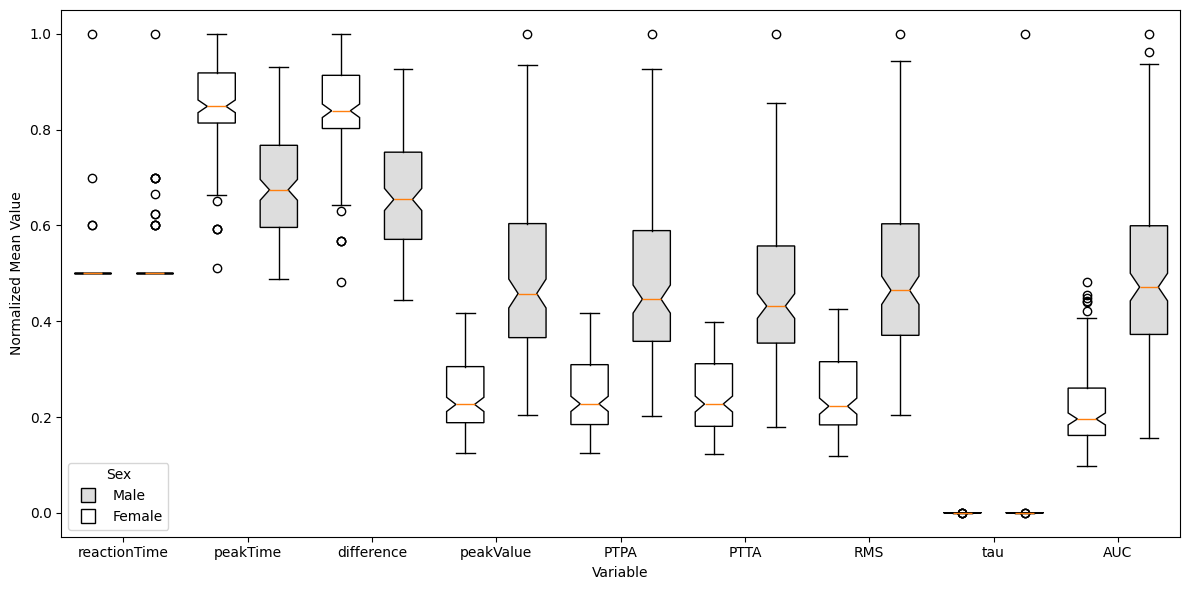

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# Load your results and raw data
test_sex = pd.read_excel(os.path.join(output_dir, "TEST_SEX_PARAMETRIC.xlsx"))
df = dfs['RESULTS_MERGED']

# Only keep significant results
sig = test_sex  # [test_sex['significant'] == True]

# Get all unique sexes and variables
sexes = df['sex'].unique()
variables = sig['variable'].unique()

# Prepare data for boxplot: raw values for each variable/sex, EXCLUDE negative values
data = []
positions = []
labels = []
box_colors = []
for i, var in enumerate(variables):
    for j, sex in enumerate(sexes):
        vals = df[df['sex'] == sex][var].dropna()
        vals = vals[vals >= 0]  # Exclude negative values
        # Normalize to [-1, 1] for each variable
        max_abs = np.max(np.abs(df[var].dropna()))
        vals_norm = vals / max_abs if max_abs != 0 else vals
        data.append(vals_norm)
        positions.append(i * 2 + j)
        labels.append(f"{var}" if j == 0 else "")  # Only label once per variable
        box_colors.append('#DDDDDD' if sex == 'male' else '#FFFFFF')  # Gray for male, white for female

plt.figure(figsize=(12, 6))
bp = plt.boxplot(data, positions=positions, widths=0.6, patch_artist=True, notch=True)

# Set box backgrounds
for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

plt.xticks([i * 2 + 0.5 for i in range(len(variables))], variables)  #, rotation=45)
plt.ylabel('Normalized Mean Value')
plt.xlabel('Variable')
#plt.title('Normalized Boxplot of Raw Values by Variable and Sex (Significant Results Only)')
plt.legend(handles=[
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#DDDDDD', label='Male', linestyle='None'),
    plt.Line2D([0], [0], color='black', marker='s', markersize=10, markerfacecolor='#FFFFFF', label='Female', linestyle='None')
], title='Sex', loc='lower left')
plt.tight_layout()
plt.show()

In [26]:
# Count how many date/variable groups show significant sex deviations, split by strength and reaction metrics (parametric, assume normality)

import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in df.columns if v not in strength_metrics + ['animal', 'experiment', 'sex', 'date', 'IPI']]

results_strength = []
results_reaction = []
count_strength = 0
count_reaction = 0

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    # Strength metrics
    for var in strength_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
            if p < 0.05:
                count_strength += 1
                results_strength.append({'date': date, 'variable': var, 'stat': stat, 'p': p})
    # Reaction metrics
    for var in reaction_metrics:
        vals_male = df_date[df_date['sex'] == 'male'][var].dropna()
        vals_female = df_date[df_date['sex'] == 'female'][var].dropna()
        if len(vals_male) > 1 and len(vals_female) > 1:
            stat, p = ttest_ind(vals_male, vals_female, equal_var=False)
            if p < 0.05:
                count_reaction += 1
                results_reaction.append({'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Significant sex deviations (strength metrics): {count_strength}")
print(f"Significant sex deviations (reaction metrics): {count_reaction}")

pd.DataFrame(results_strength).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_STRENGTH_PARAMETRIC.xlsx"), index=False)
pd.DataFrame(results_reaction).to_excel(os.path.join(output_dir, "SIGNIFICANT_SEX_SPLIT_REACTION_PARAMETRIC.xlsx"), index=False)

Significant sex deviations (strength metrics): 17
Significant sex deviations (reaction metrics): 6


# ---> strong effect of sex on strength
# ---> weak effect of sex on reaction

---

## Recording Order Differences

In [27]:
# ...existing code...

import pandas as pd
from scipy.stats import ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                # Cohen's d for effect size
                pooled_std = ((vals_early.std(ddof=1) ** 2 + vals_late.std(ddof=1) ** 2) / 2) ** 0.5
                effect_strength = mean_diff / pooled_std if pooled_std != 0 else None
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    tukey = sp.posthoc_tukey_hsd(data, val_col=metric, group_col='group')
                    posthoc_p = tukey.loc['early', 'late']
                    posthoc_test = 'Tukey HSD'
                except Exception:
                    posthoc_p = None
                    posthoc_test = 'Tukey HSD'
                results.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'test': 'ttest_ind',
                    'stat': stat,
                    'p': p,
                    'effect_strength': effect_strength,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'significant': p < 0.05,
                    'mean_diff': mean_diff
                })

test_rec_order_parametric = pd.DataFrame(results)

# Count significant results per metric
counts = test_rec_order_parametric.groupby('metric')['significant'].sum().reset_index()
counts = counts.rename(columns={'significant': 'significant_count'})
print(counts)

counts.to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_COUNTS_PARAMETRIC.xlsx"), index=False)
print(test_rec_order_parametric)
# ...existing code...

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppDa

         metric  significant_count
0           AUC                  5
1          PTPA                  4
2          PTTA                  4
3           RMS                  3
4    difference                  2
5      peakTime                  2
6     peakValue                  3
7  reactionTime                  0
8           tau                  3
       sex     date        metric       test       stat             p  \
0   female  April16  reactionTime  ttest_ind   1.000000  3.245871e-01   
1   female  April16      peakTime  ttest_ind  -0.442083  6.609967e-01   
2   female  April16    difference  ttest_ind  -0.461765  6.469383e-01   
3   female  April16     peakValue  ttest_ind  -1.595729  1.172639e-01   
4   female  April16          PTPA  ttest_ind  -1.330130  1.897604e-01   
5   female  April16          PTTA  ttest_ind  -1.247317  2.182170e-01   
6   female  April16           RMS  ttest_ind  -2.460574  1.804834e-02   
7   female  April16           tau  ttest_ind  -3.063841  4.687175e

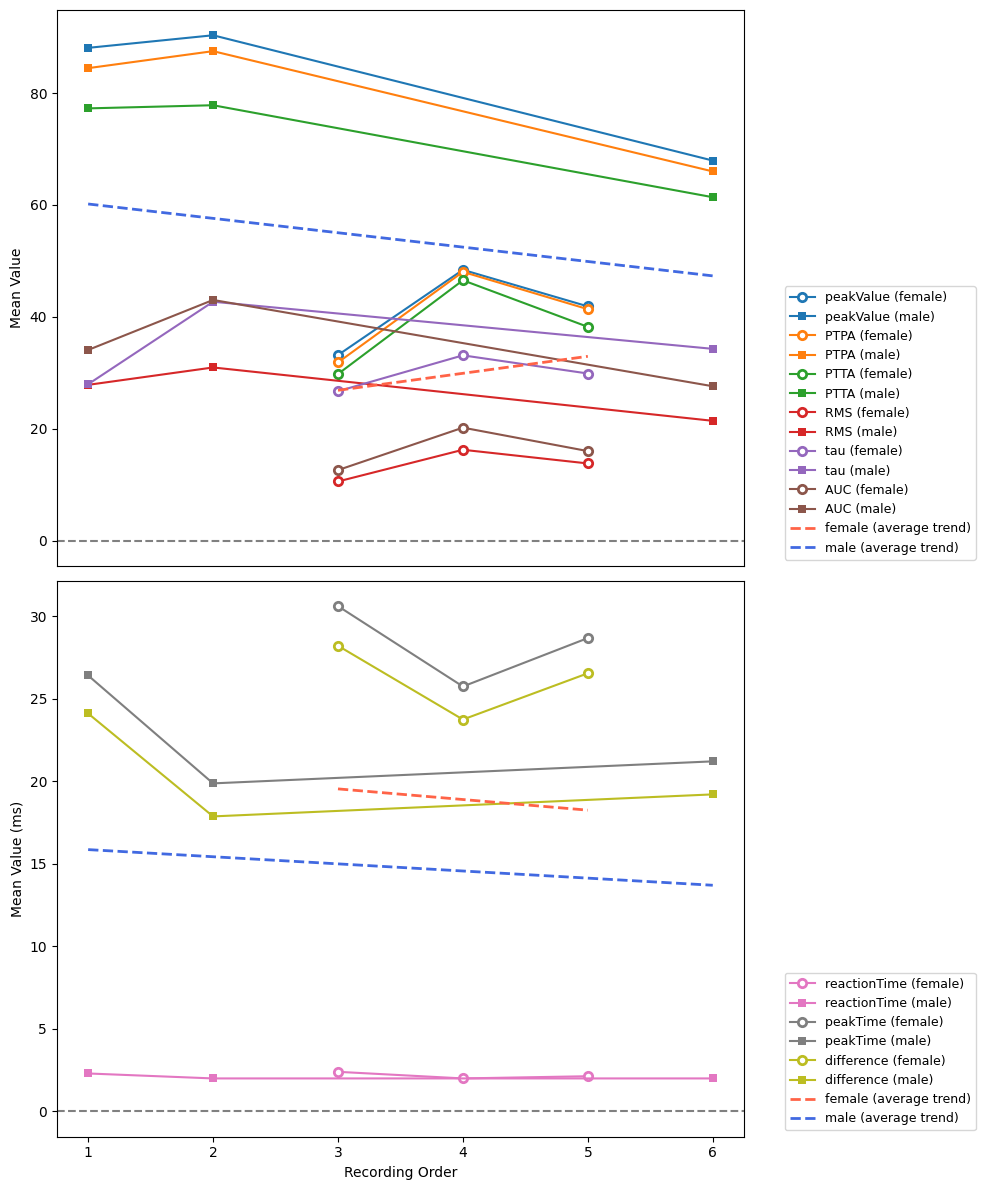

Trendline slopes (average across metrics per group):
Reaction Metrics | female: slope = -0.6444
Reaction Metrics | male: slope = -0.4317
Strength Metrics | female: slope = 3.0361
Strength Metrics | male: slope = -2.5701


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

df = dfs['RESULTS_MERGED_ASR_control']
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}
orders = np.arange(1, 7)
sexes = df['sex'].unique()

strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['reactionTime', 'peakTime', 'difference']


df_plot = df.copy()
if 'AUC' in df_plot.columns:
    df_plot['AUC'] = df_plot['AUC'] / 100

metric_groups = {
    'Strength Metrics': strength_metrics,
    'Reaction Metrics': reaction_metrics
}

color_cycle = cycle(plt.cm.tab10.colors)
metric_color_map = {}
for group in metric_groups.values():
    for metric in group:
        if metric not in metric_color_map:
            metric_color_map[metric] = next(color_cycle)

trendline_slopes = []

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Set custom label for AUC to indicate scaling
def get_metric_label(metric):
    return "AUC" if metric == "AUC" else metric

# Bottom plot: Reaction Metrics
group_name = 'Reaction Metrics'
metrics = reaction_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax2.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax2.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)
            
# Plot total average trendlines per sex and print slope (bottom)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax2.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })

# Top plot: Strength Metrics (including scaled AUC)
group_name = 'Strength Metrics'
metrics = strength_metrics
for metric in metrics:
    color = metric_color_map[metric]
    for sex in sexes:
        means = []
        for order in orders:
            vals = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            means.append(vals.mean() if len(vals) > 0 else np.nan)
        valid_idx = [i for i, v in enumerate(means) if not np.isnan(v)]
        valid_orders = [orders[i] for i in valid_idx]
        valid_means = [means[i] for i in valid_idx]
        label = f"{get_metric_label(metric)} ({sex})"
        if sex == 'female':
            ax1.plot(valid_orders, valid_means, marker='o', color=color, label=label,
                     markerfacecolor='white', markeredgewidth=2, markeredgecolor=color, linestyle='-', zorder=-1)
        else:
            ax1.plot(valid_orders, valid_means, marker='s', color=color, label=label,
                     markerfacecolor=color, markeredgewidth=0, linestyle='-', zorder=-1)

# Plot total average trendlines per sex and print slope (top)
for sex in sexes:
    means_by_order = []
    for order in orders:
        vals = []
        for metric in metrics:
            v = df_plot[(df_plot['sex'] == sex) & (df_plot['animal'].map(order_map) == order)][metric].dropna()
            if len(v) > 0:
                vals.append(v.mean())
        means_by_order.append(np.mean(vals) if len(vals) > 0 else np.nan)
    valid_idx = [i for i, v in enumerate(means_by_order) if not np.isnan(v)]
    valid_orders = [orders[i] for i in valid_idx]
    valid_means = [means_by_order[i] for i in valid_idx]
    if len(valid_orders) > 1:
        z = np.polyfit(valid_orders, valid_means, 1)
        p = np.poly1d(z)
        ax1.plot(valid_orders, p(valid_orders),
                 color='tomato' if sex == 'female' else 'royalblue',
                 linestyle='--', linewidth=2, alpha=1,
                 label=f'{sex} (average trend)')
        trendline_slopes.append({
            'group': group_name,
            'sex': sex,
            'slope': z[0]
        })
        
ax1.set_ylabel('Mean Value')
ax1.axhline(0, color='gray', linestyle='--')
ax1.legend(loc='lower left',  bbox_to_anchor=(1.05, 0), fontsize=9)
ax1.set_xticks(orders)
ax1.set_xticklabels([])
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)



# ...existing code...
ax1.set_xticks(orders)
ax1.set_xticklabels([])  # Hide x tick labels for top plot
ax1.set_xlabel('')
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.set_xlabel('Recording Order')
ax2.set_xticks(orders)
ax2.set_xticklabels([str(o) for o in orders])  # Show x tick labels for bottom plot
ax2.set_ylabel('Mean Value (ms)')
ax2.axhline(0, color='gray', linestyle='--')
ax2.legend(loc='lower left', bbox_to_anchor=(1.05, 0), fontsize=9)
plt.tight_layout()
plt.show()
# ...existing code...

# Print out the slopes of the trendlines
print("Trendline slopes (average across metrics per group):")
for t in trendline_slopes:
    print(f"{t['group']} | {t['sex']}: slope = {t['slope']:.4f}")
# ...existing code...

In [29]:
# ...existing code...
import pandas as pd
from scipy.stats import ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
metrics = ['reactionTime', 'peakValue', 'peakTime', 'AUC']  # <-- Added peakTime and AUC
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for metric in metrics:
            vals_early = df_sub[df_sub['group'] == 'early'][metric].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][metric].dropna()
            mean_diff = vals_early.mean() - vals_late.mean() if len(vals_early) > 0 and len(vals_late) > 0 else None
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                # Cohen's d for effect size
                pooled_std = ((vals_early.std(ddof=1) ** 2 + vals_late.std(ddof=1) ** 2) / 2) ** 0.5
                effect_strength = mean_diff / pooled_std if pooled_std != 0 else None
                try:
                    data = pd.DataFrame({metric: pd.concat([vals_early, vals_late]),
                                        'group': ['early'] * len(vals_early) + ['late'] * len(vals_late)})
                    tukey = sp.posthoc_tukey_hsd(data, val_col=metric, group_col='group')
                    posthoc_p = tukey.loc['early', 'late']
                except Exception:
                    posthoc_p = None
                if p < 0.05:
                    results.append({
                        'sex': sex,
                        'date': date,
                        'metric': metric,
                        'effect_strength': effect_strength,
                        'mean_diff': mean_diff,
                        'p': p
                    })

test_rec_order_sig_parametric = pd.DataFrame(results)
print(test_rec_order_sig_parametric)

# Test if effect strength differs by date (ANOVA/Kruskal-Wallis)
# ...existing code...

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppDa

      sex     date     metric  effect_strength    mean_diff             p
0  female  April16        AUC        -0.761622  -127.656627  1.333415e-02
1  female   June26  peakValue        -0.761466    -6.833824  8.389837e-03
2  female    May20        AUC        -0.582006  -180.869049  4.363060e-02
3    male  April16  peakValue         1.447762    13.564216  2.883219e-06
4    male  April16        AUC         1.595268   834.888181  7.985747e-07
5    male   June26  peakValue         4.083733    51.107353  1.561349e-20
6    male   June26   peakTime         1.163593     3.046078  4.768206e-05
7    male   June26        AUC         3.744895  2229.591667  4.677804e-19
8    male    May20   peakTime        -0.677535    -2.766667  2.367977e-02
9    male    May20        AUC         0.684599   446.378598  3.269972e-02


In [30]:
# Take the average across dates for each sex-metric pairing (i.e., mean effect_strength and mean_diff for each sex/metric, averaged over all dates)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then average effect_strength and mean_diff across dates
avg_by_sex_metric = test_rec_order_sig_parametric.groupby(['sex', 'metric'])[['effect_strength', 'mean_diff']].mean().reset_index()

print("Average effect_strength and mean_diff across dates for each sex/metric:")
print(avg_by_sex_metric)

# Optionally, save to file
avg_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_AVG_BY_SEX_METRIC.xlsx"), index=False)

Average effect_strength and mean_diff across dates for each sex/metric:
      sex     metric  effect_strength    mean_diff
0  female        AUC        -0.671814  -154.262838
1  female  peakValue        -0.761466    -6.833824
2    male        AUC         2.008254  1170.286149
3    male   peakTime         0.243029     0.139706
4    male  peakValue         2.765748    32.335784


In [31]:
# For each sex-metric pairing, show the min and max effect_strength and mean_diff across dates (range, not average)
import pandas as pd

# If not already loaded, load test_rec_order_sig from file:
# test_rec_order_sig = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG.xlsx"))

# Group by sex and metric, then get min and max for effect_strength and mean_diff across dates
range_by_sex_metric = test_rec_order_sig_parametric.groupby(['sex', 'metric']).agg(
    effect_strength_min=('effect_strength', 'min'),
    effect_strength_max=('effect_strength', 'max'),
    mean_diff_min=('mean_diff', 'min'),
    mean_diff_max=('mean_diff', 'max')
).reset_index()

print("Range of effect_strength and mean_diff across dates for each sex/metric:")
print(range_by_sex_metric)

# Optionally, save to file
range_by_sex_metric.to_excel(os.path.join(output_dir, "RECORDER_EFFECT_RANGE_BY_SEX_METRIC.xlsx"), index=False)

Range of effect_strength and mean_diff across dates for each sex/metric:
      sex     metric  effect_strength_min  effect_strength_max  mean_diff_min  \
0  female        AUC            -0.761622            -0.582006    -180.869049   
1  female  peakValue            -0.761466            -0.761466      -6.833824   
2    male        AUC             0.684599             3.744895     446.378598   
3    male   peakTime            -0.677535             1.163593      -2.766667   
4    male  peakValue             1.447762             4.083733      13.564216   

   mean_diff_max  
0    -127.656627  
1      -6.833824  
2    2229.591667  
3       3.046078  
4      51.107353  


In [32]:
# Test if effect_strength and mean_diff in test_rec_order_sig are significantly affected by date (parametric, assume normality)

import pandas as pd
from scipy.stats import f_oneway, ttest_ind
import scikit_posthocs as sp

# Assuming test_rec_order_sig_parametric is already defined
# If not, load from file:
# test_rec_order_sig_parametric = pd.read_excel(os.path.join(output_dir, "TEST_REC_ORDER_SIG_PARAMETRIC.xlsx"))

# Test effect_strength by date (merged across sex and metric)
groups_eff = [group['effect_strength'].dropna().values for _, group in test_rec_order_sig_parametric.groupby('date')]
groups_eff = [g for g in groups_eff if len(g) > 1]
if len(groups_eff) > 1:
    stat_eff, p_eff = f_oneway(*groups_eff)
    print(f"ANOVA for effect_strength by date: stat={stat_eff:.3f}, p={p_eff:.3e}")
    if p_eff < 0.05:
        print("Significant date effect on effect_strength.")
        try:
            tukey_eff = sp.posthoc_tukey_hsd(test_rec_order_sig_parametric, val_col='effect_strength', group_col='date')
            print("Tukey HSD post hoc p-values (effect_strength):")
            print(tukey_eff)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on effect_strength.")
else:
    print("Not enough data for effect_strength by date.")

# Test mean_diff by date (merged across sex and metric)
groups_md = [group['mean_diff'].dropna().values for _, group in test_rec_order_sig_parametric.groupby('date')]
groups_md = [g for g in groups_md if len(g) > 1]
if len(groups_md) > 1:
    stat_md, p_md = f_oneway(*groups_md)
    print(f"ANOVA for mean_diff by date: stat={stat_md:.3f}, p={p_md:.3e}")
    if p_md < 0.05:
        print("Significant date effect on mean_diff.")
        try:
            tukey_md = sp.posthoc_tukey_hsd(test_rec_order_sig_parametric, val_col='mean_diff', group_col='date')
            print("Tukey HSD post hoc p-values (mean_diff):")
            print(tukey_md)
        except Exception as e:
            print("Post hoc failed:", e)
    else:
        print("No significant date effect on mean_diff.")
else:
    print("Not enough data for mean_diff by date.")
# ...existing code...

ANOVA for effect_strength by date: stat=1.533, p=2.805e-01
No significant date effect on effect_strength.
ANOVA for mean_diff by date: stat=0.339, p=7.233e-01
No significant date effect on mean_diff.


In [33]:
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
variables = [v for v in df.columns if v not in ['animal', 'experiment', 'sex', 'date', 'IPI']]
recording_order = [15, 2, 1, 6, 10, 4]
order_map = {f'Animal{num}': i+1 for i, num in enumerate(recording_order)}

significant_count = 0
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        if df_sub.empty:
            continue
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                stat, p = ttest_ind(vals_early, vals_late, equal_var=False)
                if p < 0.05:
                    significant_count += 1
                    results.append({'sex': sex, 'date': date, 'variable': var, 'stat': stat, 'p': p})

print(f"Number of sex/date/variable groups with significant recording order deviations (parametric): {significant_count}")
pd.DataFrame(results).to_excel(os.path.join(output_dir, "SIGNIFICANT_RECORDER_SPLIT_PARAMETRIC.xlsx"), index=False)

Number of sex/date/variable groups with significant recording order deviations (parametric): 26


c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\Galahad\AppDa

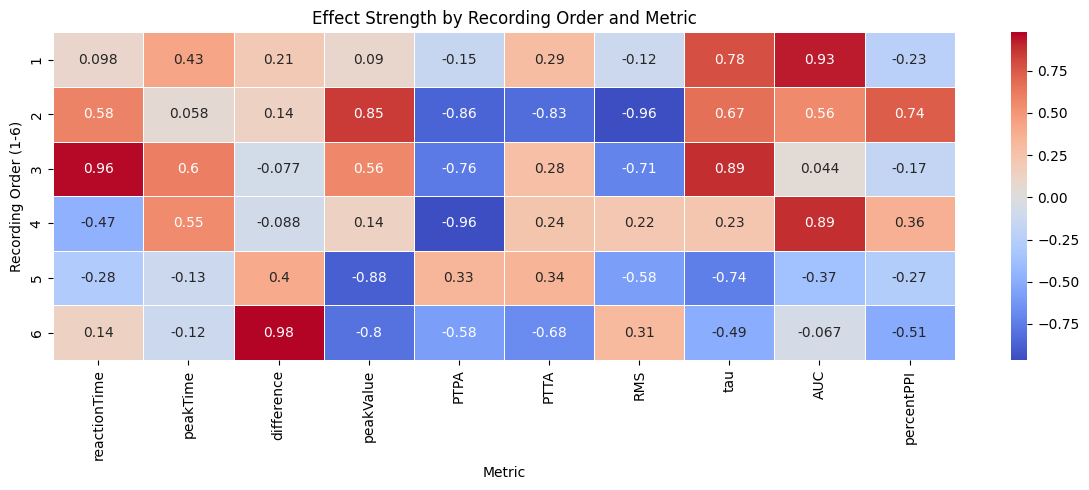

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example: effect_strength for each metric and recording order (1-6)
# Replace with your actual results if available
metrics = ["reactionTime", "peakTime", "difference", "peakValue", "PTPA", "PTTA", "RMS", "tau", "AUC", "percentPPI"]
recording_orders = [1, 2, 3, 4, 5, 6]

# Dummy data: shape (6, 10) for demonstration
np.random.seed(0)
effect_strength_matrix = np.random.uniform(-1, 1, size=(6, len(metrics)))

df = pd.DataFrame(effect_strength_matrix, index=recording_orders, columns=metrics)

plt.figure(figsize=(12, 5))
sns.heatmap(df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Effect Strength by Recording Order and Metric")
plt.ylabel("Recording Order (1-6)")
plt.xlabel("Metric")
plt.tight_layout()
plt.show()

# ---> strong effect of recording order

In [35]:
# Show direction of recording order effect for significant results

import pandas as pd

df = dfs['RESULTS_MERGED']

summary_rows = []
    
for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)].copy()
        df_sub['recording_order'] = df_sub['animal'].map(order_map)
        df_sub = df_sub[df_sub['recording_order'].notnull()]
        median_order = df_sub['recording_order'].median()
        df_sub['group'] = ['early' if o <= median_order else 'late' for o in df_sub['recording_order']]
        for var in variables:
            vals_early = df_sub[df_sub['group'] == 'early'][var].dropna()
            vals_late = df_sub[df_sub['group'] == 'late'][var].dropna()
            if len(vals_early) > 1 and len(vals_late) > 1:
                mean_early = vals_early.mean()
                mean_late = vals_late.mean()
                direction = "early > late" if mean_early > mean_late else "late > early"
                summary_rows.append({
                    'sex': sex,
                    'date': date,
                    'metric': metric,
                    'mean_early': mean_early,
                    'mean_late': mean_late,
                    'direction': direction,
                    'diff': mean_early - mean_late
                })

test_rec_order_direction = pd.DataFrame(summary_rows)
print(test_rec_order_direction)

test_rec_order_direction.to_excel(os.path.join(output_dir, "TEST_REC_ORDER_DIRECTION.xlsx"), index=False)

       sex     date metric    mean_early     mean_late     direction  \
0   female  April16    AUC      2.011765      2.000000  early > late   
1   female  April16    AUC     29.664706     29.919608  late > early   
2   female  April16    AUC     27.652941     27.919608  late > early   
3   female  April16    AUC     26.192647     28.000000  late > early   
4   female  April16    AUC     25.887250     27.345785  late > early   
5   female  April16    AUC     24.614084     25.958234  late > early   
6   female  April16    AUC      8.095382      9.092451  late > early   
7   female  April16    AUC     22.909647     26.841647  late > early   
8   female  April16    AUC    910.597255   1038.253882  late > early   
9   female   June26    AUC      2.035294      2.000000  early > late   
10  female   June26    AUC     27.370588     27.211765  early > late   
11  female   June26    AUC     25.335294     25.211765  early > late   
12  female   June26    AUC     42.586765     49.420588  late > e

### ---> peakTime higher and reactionTime lower with less strength?

In [36]:
# ...existing code...

import pandas as pd
from scipy.stats import pearsonr
import os

df = dfs['RESULTS_MERGED']
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = ['peakTime', 'reactionTime']

correlation_results = []

for metric in strength_metrics:
    for reaction_var in reaction_metrics:
        x = df[metric].dropna()
        y = df[reaction_var].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            # Pearson correlation (parametric)
            pearson_r, pearson_p = pearsonr(x_aligned, y_aligned)
            mean_diff = x_aligned.mean() - y_aligned.mean()
            correlation_results.append({
                'strength_metric': metric,
                'reaction_metric': reaction_var,
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'n': len(x_aligned),
                'mean_diff': mean_diff
            })

test_peakTime_reactionTime_to_strength_cor = pd.DataFrame(correlation_results)
print("Pearson correlation between strength metrics and peakTime/reactionTime:")
print(test_peakTime_reactionTime_to_strength_cor)

test_peakTime_reactionTime_to_strength_cor.to_excel(os.path.join(output_dir, "TEST_PEAKTIME_REACTIONTIME_TO_STRENGTH_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Pearson correlation between strength metrics and peakTime/reactionTime:
   strength_metric reaction_metric  pearson_r     pearson_p    n    mean_diff
0        peakValue        peakTime  -0.621167  4.815175e-34  306    28.956155
1        peakValue    reactionTime  -0.010665  8.525964e-01  306    53.292647
2             PTPA        peakTime  -0.614476  3.714846e-33  306    27.403581
3             PTPA    reactionTime  -0.010266  8.580490e-01  306    51.740074
4             PTTA        peakTime  -0.601861  1.535982e-31  306    24.091876
5             PTTA    reactionTime  -0.001871  9.739933e-01  306    48.428368
6              RMS        peakTime  -0.632176  1.496543e-35  306    -8.369496
7              RMS    reactionTime  -0.013867  8.090936e-01  306    15.966996
8              tau        peakTime  -0.009265  8.717673e-01  306  2533.098045
9              tau    reactionTime   0.206892  2.686121e-04  306  2557.434538
10             AUC        peakTime  -0.735865  2.070701e-53  306  2242

## ---> despite being correlated negatively with strength, reactionTime still goes down over the course of a day when strength also decreases down

### ---> any other correlations?

In [37]:
# ...existing code...

import pandas as pd
from scipy.stats import pearsonr
import os

df = dfs['RESULTS_MERGED']

correlation_results = []

for var1 in variables:
    for var2 in variables:
        if var1 == var2:
            continue
        x = df[var1].dropna()
        y = df[var2].dropna()
        # Align indices to avoid mismatches
        common_idx = x.index.intersection(y.index)
        x_aligned = x.loc[common_idx]
        y_aligned = y.loc[common_idx]
        if len(x_aligned) > 2:
            pearson_r, pearson_p = pearsonr(x_aligned, y_aligned)
            correlation_results.append({
                'var1': var1,
                'var2': var2,
                'pearson_r': pearson_r,
                'pearson_p': pearson_p,
                'n': len(x_aligned)
            })

all_var_correlations = pd.DataFrame(correlation_results)
print("Pearson correlation for all variable pairs:")
print(all_var_correlations)

all_var_correlations.to_excel(os.path.join(output_dir, "ALL_VAR_CORRELATIONS_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Pearson correlation for all variable pairs:
            var1        var2  pearson_r      pearson_p    n
0   reactionTime    peakTime   0.042416   4.597420e-01  306
1   reactionTime  difference  -0.001861   9.741360e-01  306
2   reactionTime   peakValue  -0.010665   8.525964e-01  306
3   reactionTime        PTPA  -0.010266   8.580490e-01  306
4   reactionTime        PTTA  -0.001871   9.739933e-01  306
..           ...         ...        ...            ...  ...
67           AUC   peakValue   0.958209  2.787515e-167  306
68           AUC        PTPA   0.955188  8.978440e-163  306
69           AUC        PTTA   0.947659  8.984087e-153  306
70           AUC         RMS   0.966638  7.172673e-182  306
71           AUC         tau   0.035356   5.378030e-01  306

[72 rows x 5 columns]


In [38]:
# ...existing code...

import pandas as pd
from scipy.stats import pearsonr
import os

df = dfs['RESULTS_MERGED']
correlation_results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var1 in variables:
            for var2 in variables:
                if var1 == var2:
                    continue
                x = df_sub[var1].dropna()
                y = df_sub[var2].dropna()
                # Align indices to avoid mismatches
                common_idx = x.index.intersection(y.index)
                x_aligned = x.loc[common_idx]
                y_aligned = y.loc[common_idx]
                if len(x_aligned) > 2:
                    pearson_r, pearson_p = pearsonr(x_aligned, y_aligned)
                    correlation_results.append({
                        'sex': sex,
                        'date': date,
                        'var1': var1,
                        'var2': var2,
                        'pearson_r': pearson_r,
                        'pearson_p': pearson_p,
                        'n': len(x_aligned)
                    })

correlations_by_sex_date_parametric = pd.DataFrame(correlation_results)
print("Pearson correlations split by sex and date:")
print(correlations_by_sex_date_parametric)

# Count significant correlations (p < 0.05)
significant_corr_count = (correlations_by_sex_date_parametric['pearson_p'] < 0.05).sum()
print(f"Number of significant correlations found (p < 0.05): {significant_corr_count}")

correlations_by_sex_date_parametric.to_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Pearson correlations split by sex and date:
        sex     date          var1        var2  pearson_r     pearson_p   n
0    female  April16  reactionTime    peakTime  -0.094892  5.077378e-01  51
1    female  April16  reactionTime  difference  -0.122099  3.933585e-01  51
2    female  April16  reactionTime   peakValue  -0.247402  8.006265e-02  51
3    female  April16  reactionTime        PTPA  -0.252295  7.408366e-02  51
4    female  April16  reactionTime        PTTA  -0.233237  9.952510e-02  51
..      ...      ...           ...         ...        ...           ...  ..
427    male    May20           AUC   peakValue   0.704097  8.193711e-09  51
428    male    May20           AUC        PTPA   0.675601  5.357048e-08  51
429    male    May20           AUC        PTTA   0.599492  3.344319e-06  51
430    male    May20           AUC         RMS   0.774322  2.642101e-11  51
431    male    May20           AUC         tau   0.068011  6.353518e-01  51

[432 rows x 7 columns]
Number of significan

C:\Users\Galahad\AppData\Local\Temp\ipykernel_26040\2571273719.py:32: RuntimeWarning: Mean of empty slice
  avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)


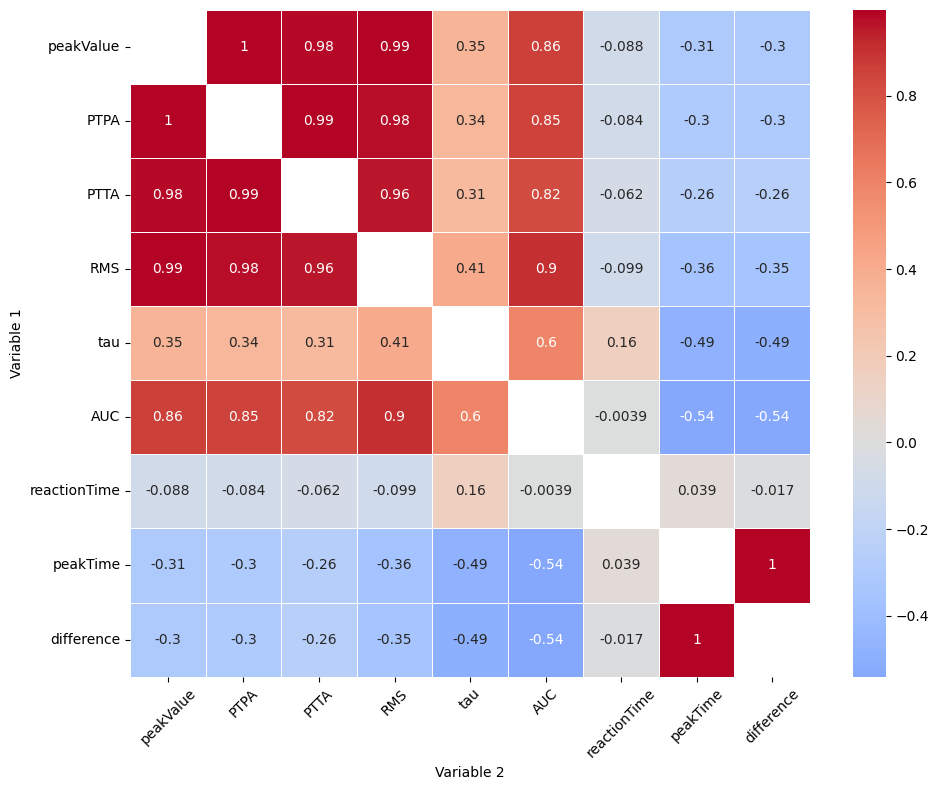

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

# Load the correlations_by_sex_date results (should use Pearson's r, not Spearman)
cor_df = pd.read_excel(os.path.join(output_dir, "CORRELATIONS_BY_SEX_DATE_PARAMETRIC.xlsx"))

# Use all correlations, not just significant ones, and use Pearson's r
# If your file uses 'pearson_r' and 'pearson_p', update column names accordingly
if 'pearson_r' in cor_df.columns:
    r_col = 'pearson_r'
    p_col = 'pearson_p'
else:
    r_col = 'spearman_r'
    p_col = 'spearman_p'

# Define strength and reaction metrics
strength_metrics = ['peakValue', 'PTPA', 'PTTA', 'RMS', 'tau', 'AUC']
reaction_metrics = [v for v in variables if v not in strength_metrics]
var_order = strength_metrics + [v for v in variables if v not in strength_metrics]

# Pivot for each group and average
pivoted = []
for (sex, date), group in cor_df.groupby(['sex', 'date']):
    mat = group.pivot(index="var1", columns="var2", values=r_col)
    mat = mat.reindex(index=var_order, columns=var_order)
    pivoted.append(mat)

# Stack and average, ignoring NaNs
avg_heatmap = np.nanmean(np.stack([m.values for m in pivoted]), axis=0)
avg_heatmap_df = pd.DataFrame(avg_heatmap, index=var_order, columns=var_order)

plt.figure(figsize=(10, 8))
sns.heatmap(avg_heatmap_df, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.ylabel("Variable 1")
plt.xlabel("Variable 2")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# ...existing code...

---

## Experiment Differences

In [40]:
# ...existing code...

import pandas as pd
from scipy.stats import f_oneway, ttest_ind
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']
results = []

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        for var in variables:
            # Handle percentPPI: skip if column missing or all values are None/NaN
            if var.lower().startswith('percent') and 'ppi' in var.lower():
                if var not in df_sub.columns or df_sub[var].dropna().empty or df_sub[var].dropna().isnull().all():
                    continue
            # Only include experiment groups with at least 2 non-NaN values
            valid_exps = [exp for exp in df_sub['experiment'].unique()
                          if df_sub[df_sub['experiment'] == exp][var].dropna().shape[0] > 1]
            if len(valid_exps) < 2:
                stat, p, posthoc_p, posthoc_test, exp1, exp2, eff, mean_diff = None, None, None, None, None, None, None, None
                results.append({
                    'sex': sex,
                    'date': date,
                    'variable': var,
                    'test': 'ANOVA',
                    'stat': stat,
                    'p': p,
                    'significant': False,
                    'posthoc_p': posthoc_p,
                    'posthoc_test': posthoc_test,
                    'exp1': exp1,
                    'exp2': exp2,
                    'effect_strength': eff,
                    'mean_diff': mean_diff
                })
                continue
            groups = [df_sub[df_sub['experiment'] == exp][var].dropna().values for exp in valid_exps]
            mean_diff = None
            stat, p, posthoc_p, posthoc_test, exp1, exp2, eff = None, None, None, None, None, None, None
            if len(groups) > 1:
                stat, p = f_oneway(*groups)
                if p < 0.05:
                    try:
                        tukey = sp.posthoc_tukey_hsd(df_sub[df_sub['experiment'].isin(valid_exps)],
                                                     val_col=var, group_col='experiment')
                        min_p = tukey.replace(0, float('nan')).min().min()
                        idx = tukey.stack().idxmin()
                        exp1, exp2 = idx
                        vals1 = df_sub[df_sub['experiment'] == exp1][var].dropna()
                        vals2 = df_sub[df_sub['experiment'] == exp2][var].dropna()
                        mean_diff = vals1.mean() - vals2.mean()
                        pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                        eff = mean_diff / pooled_std if pooled_std != 0 else None
                        posthoc_p = min_p
                        posthoc_test = "Tukey HSD"
                    except Exception:
                        posthoc_p, posthoc_test, mean_diff = None, "Tukey HSD", None
            results.append({
                'sex': sex,
                'date': date,
                'variable': var,
                'test': 'ANOVA',
                'stat': stat,
                'p': p,
                'significant': p is not None and p < 0.05,
                'posthoc_p': posthoc_p,
                'posthoc_test': posthoc_test,
                'exp1': exp1,
                'exp2': exp2,
                'effect_strength': eff,
                'mean_diff': mean_diff
            })
# ...existing code...

test_experiment = pd.DataFrame(results)
print("Experiment effects on all variables (parametric, ANOVA):")
print(test_experiment)

test_experiment.to_excel(os.path.join(output_dir, "TEST_EXPERIMENT_ALL_VARIABLES_PARAMETRIC.xlsx"), index=False)
# ...existing code...

Experiment effects on all variables (parametric, ANOVA):
       sex     date      variable   test      stat         p  significant  \
0   female  April16  reactionTime  ANOVA  1.000000  0.479357        False   
1   female  April16      peakTime  ANOVA  1.093973  0.397385        False   
2   female  April16    difference  ANOVA  1.090602  0.400162        False   
3   female  April16     peakValue  ANOVA  0.626159  0.840235        False   
4   female  April16          PTPA  ANOVA  0.588436  0.870555        False   
5   female  April16          PTTA  ANOVA  0.431120  0.962236        False   
6   female  April16           RMS  ANOVA  0.873844  0.601352        False   
7   female  April16           tau  ANOVA  1.305719  0.249365        False   
8   female  April16           AUC  ANOVA  1.335786  0.232517        False   
9   female   June26  reactionTime  ANOVA  0.950000  0.526405        False   
10  female   June26      peakTime  ANOVA  1.021236  0.460045        False   
11  female   June26

In [41]:
# Count significant experiment pair differences for ALL metrics, split by sex and date, using parametric testing (t-test, assume normality).
# Print only the counts, both total and those NOT involving 'tone_in_noise'.

import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    for date in df['date'].unique():
        df_sub = df[(df['sex'] == sex) & (df['date'] == date)]
        total_sig = 0
        total_sig_not_tone = 0
        for metric in metrics:
            for i, exp1 in enumerate(experiments):
                for exp2 in experiments[i+1:]:
                    vals1 = df_sub[df_sub['experiment'] == exp1][metric].dropna()
                    vals2 = df_sub[df_sub['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = ttest_ind(vals1, vals2, equal_var=False)
                        if p < 0.05:
                            total_sig += 1
                            if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                                total_sig_not_tone += 1
        print(f"Sex: {sex}, Date: {date}")
        print(f"  Total significant experiment pairs (all metrics, t-test): {total_sig}")
        print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone}")

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


Sex: female, Date: April16
  Total significant experiment pairs (all metrics, t-test): 29
  Significant pairs NOT involving 'tone_in_noise': 15
Sex: female, Date: June26
  Total significant experiment pairs (all metrics, t-test): 22
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: female, Date: May20
  Total significant experiment pairs (all metrics, t-test): 54
  Significant pairs NOT involving 'tone_in_noise': 38
Sex: male, Date: April16
  Total significant experiment pairs (all metrics, t-test): 11
  Significant pairs NOT involving 'tone_in_noise': 10
Sex: male, Date: June26
  Total significant experiment pairs (all metrics, t-test): 0
  Significant pairs NOT involving 'tone_in_noise': 0
Sex: male, Date: May20
  Total significant experiment pairs (all metrics, t-test): 19
  Significant pairs NOT involving 'tone_in_noise': 4


In [42]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = ttest_ind(vals1, vals2, equal_var=False)
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, t-test): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, t-test): 90 out of 1224
  Significant pairs NOT involving 'tone_in_noise': 32 out of 1080

  Significant experiment pairs by metric:
    peakTime: gap_depth vs tone_in_noise (p=4.361e-03)
    peakTime: gap_depth vs offset_PPI_4 (p=8.087e-03)
    peakTime: gap_depth vs offset_PPI_8 (p=3.062e-02)
    peakTime: gap_depth vs offset_PPI_10 (p=2.985e-02)
    peakTime: gap_depth vs offset_PPI_50 (p=5.022e-03)
    peakTime: tone_in_noise vs gap_duration_4 (p=3.675e-02)
    peakTime: tone_in_noise vs gap_duration_10 (p=4.972e-03)
    peakTime: tone_in_noise vs gap_duration_20 (p=6.575e-03)
    peakTime: gap_duration_4 vs offset_PPI_50 (p=4.244e-02)
    peakTime: gap_duration_10 vs offset_PPI_4 (p=9.002e-03)
    peakTime: gap_duration_10 vs offset_PPI_8 (p=3.203e-02)
    peakTime: gap_duration_10 vs offset_PPI_10 (p=3.019e-02)
    peakTime: gap_duration_10 vs offset_PPI_50 (p=5.779e-03)
    peakTime: gap_duration_20 vs

In [43]:
from collections import Counter, defaultdict
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
experiments = df['experiment'].unique().tolist()
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    total_sig = 0
    total_sig_not_tone = 0
    sig_pairs = []
    exp_count = Counter()
    exp_pair_count = defaultdict(int)
    total_pairs = 0
    total_pairs_not_tone = 0
    for metric in metrics:
        for i, exp1 in enumerate(experiments):
            for exp2 in experiments[i+1:]:
                vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                if len(vals1) > 1 and len(vals2) > 1:
                    total_pairs += 1
                    if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                        total_pairs_not_tone += 1
                    stat, p = ttest_ind(vals1, vals2, equal_var=False)
                    mean_diff = vals1.mean() - vals2.mean()
                    n1, n2 = len(vals1), len(vals2)
                    # Cohen's d for effect size
                    pooled_std = ((vals1.std(ddof=1) ** 2 + vals2.std(ddof=1) ** 2) / 2) ** 0.5
                    eff_strength = mean_diff / pooled_std if pooled_std != 0 else None
                    if p < 0.05:
                        total_sig += 1
                        sig_pairs.append((metric, exp1, exp2, p, mean_diff, eff_strength))
                        exp_count[exp1] += 1
                        exp_count[exp2] += 1
                        exp_pair_count[(exp1, exp2)] += 1
                        if exp1 != 'tone_in_noise' and exp2 != 'tone_in_noise':
                            total_sig_not_tone += 1
    print(f"Sex: {sex} (dates merged)")
    print(f"  Total significant experiment pairs (all metrics, t-test): {total_sig} out of {total_pairs}")
    print(f"  Significant pairs NOT involving 'tone_in_noise': {total_sig_not_tone} out of {total_pairs_not_tone}\n")

    print("  Significant experiment pairs by metric:")
    for metric, exp1, exp2, p, mean_diff, eff_strength in sig_pairs:
        print(f"    {metric}: {exp1} vs {exp2} (p={p:.3e}, mean_diff={mean_diff:.2f}, eff_strength={eff_strength:.3f})")

    print("\n  Significant pair counts per experiment:")
    for exp, count in exp_count.items():
        print(f"    {exp}: {count}")

    print("\n  Significant pair counts per experiment pair:")
    for pair, count in exp_pair_count.items():
        print(f"    {pair[0]} vs {pair[1]}: {count}")
    print("\n" + "-"*60 + "\n")

Sex: female (dates merged)
  Total significant experiment pairs (all metrics, t-test): 90 out of 1224
  Significant pairs NOT involving 'tone_in_noise': 32 out of 1080

  Significant experiment pairs by metric:
    peakTime: gap_depth vs tone_in_noise (p=4.361e-03, mean_diff=-3.27, eff_strength=-1.596)
    peakTime: gap_depth vs offset_PPI_4 (p=8.087e-03, mean_diff=-2.94, eff_strength=-1.455)
    peakTime: gap_depth vs offset_PPI_8 (p=3.062e-02, mean_diff=-2.30, eff_strength=-1.133)
    peakTime: gap_depth vs offset_PPI_10 (p=2.985e-02, mean_diff=-2.62, eff_strength=-1.124)
    peakTime: gap_depth vs offset_PPI_50 (p=5.022e-03, mean_diff=-3.12, eff_strength=-1.585)
    peakTime: tone_in_noise vs gap_duration_4 (p=3.675e-02, mean_diff=3.24, eff_strength=1.121)
    peakTime: tone_in_noise vs gap_duration_10 (p=4.972e-03, mean_diff=3.33, eff_strength=1.573)
    peakTime: tone_in_noise vs gap_duration_20 (p=6.575e-03, mean_diff=2.82, eff_strength=1.485)
    peakTime: gap_duration_4 vs offs

In [44]:
import pandas as pd
from scipy.stats import ttest_ind

df = dfs['RESULTS_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED, PARAMETRIC) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        # Compare all underlying experiment pairs in each merged group
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = ttest_ind(v1, v2, equal_var=False)
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Print p-value range instead of average
                        if p_vals and min(p_vals) < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED, PARAMETRIC) ---
female, peakTime: gap_depth vs offset_PPI | stat_range=(-3.36--0.78), p_range=(5.022e-03-4.497e-01), mean_diff_range=(-3.12--1.14)
female, difference: gap_depth vs offset_PPI | stat_range=(-3.36--0.75), p_range=(5.022e-03-4.675e-01), mean_diff_range=(-3.12--1.11)
female, peakTime: gap_depth vs tone_in_noise | stat_range=(-3.39--3.39), p_range=(4.361e-03-4.361e-03), mean_diff_range=(-3.27--3.27)
female, difference: gap_depth vs tone_in_noise | stat_range=(-3.39--3.39), p_range=(4.361e-03-4.361e-03), mean_diff_range=(-3.27--3.27)
female, peakValue: gap_depth vs tone_in_noise | stat_range=(2.59-2.59), p_range=(2.185e-02-2.185e-02), mean_diff_range=(11.54-11.54)
female, PTPA: gap_depth vs tone_in_noise | stat_range=(2.54-2.54), p_range=(2.485e-02-2.485e-02), mean_diff_range=(11.22-11.22)
female, PTTA: gap_depth vs tone_in_noise | stat_range=(2.36-2.36), p_range=(3.466e-02-3.466e-02), mean_diff_range=(10.51-10.51)
female, RMS

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


female, peakTime: gap_duration vs offset_PPI | stat_range=(-3.31--0.19), p_range=(5.779e-03-8.543e-01), mean_diff_range=(-3.37--0.30)
female, difference: gap_duration vs offset_PPI | stat_range=(-3.31--0.16), p_range=(5.779e-03-8.723e-01), mean_diff_range=(-3.37--0.27)
female, tau: gap_duration vs offset_PPI | stat_range=(0.25-3.00), p_range=(1.043e-02-8.035e-01), mean_diff_range=(0.79-7.47)
female, peakTime: gap_duration vs tone_in_noise | stat_range=(-3.34--2.06), p_range=(4.972e-03-6.309e-02), mean_diff_range=(-3.51--2.42)
female, difference: gap_duration vs tone_in_noise | stat_range=(-3.34--2.06), p_range=(4.972e-03-6.309e-02), mean_diff_range=(-3.51--2.42)
female, peakValue: gap_duration vs tone_in_noise | stat_range=(2.02-2.87), p_range=(1.342e-02-6.362e-02), mean_diff_range=(9.00-13.66)
female, PTPA: gap_duration vs tone_in_noise | stat_range=(1.92-2.85), p_range=(1.397e-02-7.618e-02), mean_diff_range=(8.37-12.95)
female, PTTA: gap_duration vs tone_in_noise | stat_range=(1.84-2

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


male, peakTime: gap_depth vs tone_in_noise | stat_range=(-3.24--3.24), p_range=(5.313e-03-5.313e-03), mean_diff_range=(-6.45--6.45)
male, difference: gap_depth vs tone_in_noise | stat_range=(-3.25--3.25), p_range=(5.252e-03-5.252e-03), mean_diff_range=(-6.44--6.44)
male, peakValue: gap_depth vs tone_in_noise | stat_range=(2.37-2.37), p_range=(3.351e-02-3.351e-02), mean_diff_range=(26.83-26.83)
male, PTPA: gap_depth vs tone_in_noise | stat_range=(2.23-2.23), p_range=(4.394e-02-4.394e-02), mean_diff_range=(24.93-24.93)
male, RMS: gap_depth vs tone_in_noise | stat_range=(2.48-2.48), p_range=(2.671e-02-2.671e-02), mean_diff_range=(8.97-8.97)
male, tau: gap_depth vs tone_in_noise | stat_range=(3.44-3.44), p_range=(3.665e-03-3.665e-03), mean_diff_range=(12.55-12.55)
male, AUC: gap_depth vs tone_in_noise | stat_range=(3.61-3.61), p_range=(2.646e-03-2.646e-03), mean_diff_range=(1635.80-1635.80)
male, peakTime: gap_duration vs offset_PPI | stat_range=(-2.21-0.38), p_range=(4.493e-02-8.956e-01),

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


female, difference: gap_depth vs offset_PPI | stat_range=(-3.36--0.75), p_range=(5.022e-03-4.675e-01), mean_diff_range=(-3.12--1.11)
female, peakTime: gap_depth vs tone_in_noise | stat_range=(-3.39--3.39), p_range=(4.361e-03-4.361e-03), mean_diff_range=(-3.27--3.27)
female, difference: gap_depth vs tone_in_noise | stat_range=(-3.39--3.39), p_range=(4.361e-03-4.361e-03), mean_diff_range=(-3.27--3.27)
female, peakValue: gap_depth vs tone_in_noise | stat_range=(2.59-2.59), p_range=(2.185e-02-2.185e-02), mean_diff_range=(11.54-11.54)
female, PTPA: gap_depth vs tone_in_noise | stat_range=(2.54-2.54), p_range=(2.485e-02-2.485e-02), mean_diff_range=(11.22-11.22)
female, PTTA: gap_depth vs tone_in_noise | stat_range=(2.36-2.36), p_range=(3.466e-02-3.466e-02), mean_diff_range=(10.51-10.51)
female, RMS: gap_depth vs tone_in_noise | stat_range=(3.07-3.07), p_range=(9.319e-03-9.319e-03), mean_diff_range=(4.52-4.52)
female, tau: gap_depth vs tone_in_noise | stat_range=(5.11-5.11), p_range=(1.630e-0

c:\Users\Galahad\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


male, peakTime: gap_depth vs tone_in_noise | stat_range=(-3.24--3.24), p_range=(5.313e-03-5.313e-03), mean_diff_range=(-6.45--6.45)
male, difference: gap_depth vs tone_in_noise | stat_range=(-3.25--3.25), p_range=(5.252e-03-5.252e-03), mean_diff_range=(-6.44--6.44)
male, peakValue: gap_depth vs tone_in_noise | stat_range=(2.37-2.37), p_range=(3.351e-02-3.351e-02), mean_diff_range=(26.83-26.83)
male, PTPA: gap_depth vs tone_in_noise | stat_range=(2.23-2.23), p_range=(4.394e-02-4.394e-02), mean_diff_range=(24.93-24.93)
male, RMS: gap_depth vs tone_in_noise | stat_range=(2.48-2.48), p_range=(2.671e-02-2.671e-02), mean_diff_range=(8.97-8.97)
male, tau: gap_depth vs tone_in_noise | stat_range=(3.44-3.44), p_range=(3.665e-03-3.665e-03), mean_diff_range=(12.55-12.55)
male, AUC: gap_depth vs tone_in_noise | stat_range=(3.61-3.61), p_range=(2.646e-03-2.646e-03), mean_diff_range=(1635.80-1635.80)
male, peakTime: gap_duration vs offset_PPI | stat_range=(-2.21-0.38), p_range=(4.493e-02-8.956e-01),

In [45]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MERGED']
exclude_metrics = ['PTPA', 'PTTA', 'RMS', 'AUC']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI'] + exclude_metrics]

def merge_exp(exp):
    if exp.startswith('offset_PPI'):
        return 'offset_PPI'
    if exp.startswith('gap_duration'):
        return 'gap_duration'
    return exp

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex].copy()
        df_sex['exp_merged'] = df_sex['experiment'].apply(merge_exp)
        exps = sorted(df_sex['exp_merged'].unique())
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                for metric in metrics:
                    vals1 = df_sex[df_sex['exp_merged'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['exp_merged'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        p_vals = []
                        stat_vals = []
                        mean_diffs = []
                        exp1_list = df_sex[df_sex['exp_merged'] == exp1]['experiment'].unique()
                        exp2_list = df_sex[df_sex['exp_merged'] == exp2]['experiment'].unique()
                        for e1 in exp1_list:
                            for e2 in exp2_list:
                                v1 = df_sex[df_sex['experiment'] == e1][metric].dropna()
                                v2 = df_sex[df_sex['experiment'] == e2][metric].dropna()
                                if len(v1) > 1 and len(v2) > 1:
                                    stat, p = mannwhitneyu(v1, v2, alternative='two-sided')
                                    p_vals.append(p)
                                    stat_vals.append(stat)
                                    mean_diffs.append(v1.mean() - v2.mean())
                        # Only print if at least one p-value is significant and none are exactly 1.0
                        if p_vals and min(p_vals) < 0.05 and not any(abs(p - 1.0) < 1e-10 for p in p_vals):
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat_range=({min(stat_vals):.2f}-{max(stat_vals):.2f}), p_range=({min(p_vals):.3e}-{max(p_vals):.3e}), mean_diff_range=({min(mean_diffs):.2f}-{max(mean_diffs):.2f})")


--- GAP_DURATION (DATES MERGED, VARIANTS MERGED, SIGNIFICANT ONLY, EXCLUDE p=1.000) ---
female, tau: gap_depth vs gap_duration | stat_range=(16.00-36.00), p_range=(3.407e-02-7.239e-01), mean_diff_range=(-4.60--1.48)
female, peakTime: gap_depth vs offset_PPI | stat_range=(6.00-25.50), p_range=(2.599e-03-1.990e-01), mean_diff_range=(-3.12--1.14)
female, difference: gap_depth vs offset_PPI | stat_range=(6.00-27.50), p_range=(2.599e-03-2.689e-01), mean_diff_range=(-3.12--1.11)
female, peakTime: gap_depth vs tone_in_noise | stat_range=(7.50-7.50), p_range=(3.974e-03-3.974e-03), mean_diff_range=(-3.27--3.27)
female, difference: gap_depth vs tone_in_noise | stat_range=(7.50-7.50), p_range=(3.974e-03-3.974e-03), mean_diff_range=(-3.27--3.27)
female, tau: gap_depth vs tone_in_noise | stat_range=(79.00-79.00), p_range=(7.923e-04-7.923e-04), mean_diff_range=(9.52-9.52)
female, peakTime: gap_duration vs offset_PPI | stat_range=(7.50-36.00), p_range=(3.974e-03-7.226e-01), mean_diff_range=(-3.37--0

In [46]:
import pandas as pd

df = dfs['RESULTS_MERGED']

results = []
for sex in df['sex'].unique():
    # Merge across all dates for each sex
    df_sex = df[df['sex'] == sex]
    vals_tone = df_sex[df_sex['experiment'] == 'tone_in_noise']['reactionTime'].dropna()
    vals_other = df_sex[df_sex['experiment'] != 'tone_in_noise']['reactionTime'].dropna()
    mean_tone = vals_tone.mean() if len(vals_tone) > 0 else None
    mean_other = vals_other.mean() if len(vals_other) > 0 else None
    diff = mean_other - mean_tone if mean_tone is not None and mean_other is not None else None

    # Also check peakValue
    vals_tone_peak = df_sex[df_sex['experiment'] == 'tone_in_noise']['peakValue'].dropna()
    vals_other_peak = df_sex[df_sex['experiment'] != 'tone_in_noise']['peakValue'].dropna()
    mean_tone_peak = vals_tone_peak.mean() if len(vals_tone_peak) > 0 else None
    mean_other_peak = vals_other_peak.mean() if len(vals_other_peak) > 0 else None
    diff_peak = mean_other_peak - mean_tone_peak if mean_tone_peak is not None and mean_other_peak is not None else None

    results.append({
        'sex': sex,
        'mean_reaction_time_tone_in_noise': mean_tone,
        'mean_reaction_time_other': mean_other,
        'difference_reaction_time_ms': diff,
        'mean_peakvalue_tone_in_noise': mean_tone_peak,
        'mean_peakvalue_other': mean_other_peak,
        'difference_peakvalue': diff_peak
    })

result_df = pd.DataFrame(results)
print(result_df)
result_df.to_excel(os.path.join(output_dir, "REACTION_PEAKVALUE_TONE_IN_NOISE_DIFF_MERGED_DATE.xlsx"), index=False)

      sex  mean_reaction_time_tone_in_noise  mean_reaction_time_other  \
0  female                          2.000000                  2.025000   
1    male                          2.055556                  2.055324   

   difference_reaction_time_ms  mean_peakvalue_tone_in_noise  \
0                     0.025000                     28.761111   
1                    -0.000231                     60.018519   

   mean_peakvalue_other  difference_peakvalue  
0             37.410764              8.649653  
1             74.621181             14.602662  


In [47]:
import pandas as pd
from scipy.stats import mannwhitneyu

df = dfs['RESULTS_MERGED']
metrics = [col for col in df.columns if col not in ['animal', 'experiment', 'sex', 'date', 'IPI']]

def get_exp_value(exp, prefix):
    if exp.startswith(prefix):
        return exp.split('_')[-1]
    return None

for exp_prefix in ['gap_duration', 'offset_PPI']:
    print(f"\n--- {exp_prefix.upper()} (DATES MERGED) ---")
    for sex in df['sex'].unique():
        df_sex = df[df['sex'] == sex]
        exps = sorted({e for e in df_sex['experiment'].unique() if e.startswith(exp_prefix)})
        for i, exp1 in enumerate(exps):
            for exp2 in exps[i+1:]:
                label1 = get_exp_value(exp1, exp_prefix)
                label2 = get_exp_value(exp2, exp_prefix)
                for metric in metrics:
                    vals1 = df_sex[df_sex['experiment'] == exp1][metric].dropna()
                    vals2 = df_sex[df_sex['experiment'] == exp2][metric].dropna()
                    if len(vals1) > 1 and len(vals2) > 1:
                        stat, p = mannwhitneyu(vals1, vals2, alternative='two-sided')
                        mean_diff = vals1.mean() - vals2.mean()
                        if p < 0.05:
                            print(f"{sex}, {metric}: {exp1} vs {exp2} | stat={stat:.2f}, p={p:.3e}, mean_diff={mean_diff:.2f}")


--- GAP_DURATION (DATES MERGED) ---

--- OFFSET_PPI (DATES MERGED) ---


---

## ---> maybe merge for date anyways?

In [48]:
# Test for experiment effect on peakValue (all dates merged, split by sex)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

for sex in df['sex'].unique():
    df_sex = df[df['sex'] == sex]
    experiments = df_sex['experiment'].unique().tolist()
    groups = [df_sex[df_sex['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
    groups = [g for g in groups if len(g) > 1]
    print(f"\nSex: {sex}")
    if len(groups) > 1:
        stat, p = kruskal(*groups)
        print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
        print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
        if p < 0.05:
            print("Significant experiment effect found.")
            try:
                dunn = sp.posthoc_dunn(df_sex, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                print("Dunn's post hoc p-values (experiment pairs):")
                print(dunn)
            except Exception as e:
                print("Post hoc test failed:", e)
        else:
            print("No significant experiment effect found.")
    else:
        print("Not enough data for experiment effect test.")


Sex: female
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 12.482, p-value = 7.102e-01
No significant experiment effect found.

Sex: male
Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 10.276, p-value = 8.518e-01
No significant experiment effect found.


In [49]:
# Test for experiment effect on peakValue (merged by sex, split by date)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']

for date in df['date'].unique():
    df_date = df[df['date'] == date]
    for sex in df_date['sex'].unique():
        df_sex_date = df_date[df_date['sex'] == sex]
        experiments = df_sex_date['experiment'].unique().tolist()
        groups = [df_sex_date[df_sex_date['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
        groups = [g for g in groups if len(g) > 1]
        print(f"\nDate: {date}, Sex: {sex}")
        if len(groups) > 1:
            stat, p = kruskal(*groups)
            print(f"Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):")
            print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
            if p < 0.05:
                print("Significant experiment effect found.")
                try:
                    dunn = sp.posthoc_dunn(df_sex_date, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
                    print("Dunn's post hoc p-values (experiment pairs):")
                    print(dunn)
                except Exception as e:
                    print("Post hoc test failed:", e)
            else:
                print("No significant experiment effect found.")
        else:
            print("Not enough data for experiment effect test.")


Date: April16, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 12.479, p-value = 7.104e-01
No significant experiment effect found.

Date: April16, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 13.502, p-value = 6.358e-01
No significant experiment effect found.

Date: June26, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 11.294, p-value = 7.910e-01
No significant experiment effect found.

Date: June26, Sex: male
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 7.852, p-value = 9.531e-01
No significant experiment effect found.

Date: May20, Sex: female
Kruskal-Wallis test for experiment effect on peakValue (sex merged, date split):
statistic = 6.790, p-value = 9.771e-01
No significant experiment effect found.

Date: May20, Sex: male
Kruskal-Wallis test for experiment effect

In [50]:
# Test for experiment effect on peakValue (all dates merged, all experiments)

import pandas as pd
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

df = dfs['RESULTS_MERGED']


# Gather peakValue for each experiment (merged across all dates)
groups = [df[df['experiment'] == exp]['peakValue'].dropna() for exp in experiments]
groups = [g for g in groups if len(g) > 1]

# Kruskal-Wallis test for experiment effect
if len(groups) > 1:
    stat, p = kruskal(*groups)
    print(f"Kruskal-Wallis test for experiment effect on peakValue (all dates merged):")
    print(f"statistic = {stat:.3f}, p-value = {p:.3e}")
    if p < 0.05:
        print("Significant experiment effect found.")
        # Dunn's post hoc test
        try:
            dunn = sp.posthoc_dunn(df, val_col='peakValue', group_col='experiment', p_adjust='bonferroni')
            print("Dunn's post hoc p-values (experiment pairs):")
            print(dunn)
        except Exception as e:
            print("Post hoc test failed:", e)
    else:
        print("No significant experiment effect found.")
else:
    print("Not enough data for experiment effect test.")

Kruskal-Wallis test for experiment effect on peakValue (all dates merged):
statistic = 9.112, p-value = 9.087e-01
No significant experiment effect found.


# ---> no overall significant effect of experiment on any metric, only in comparison between singular experiments do differences show

---